# Introduction

Running the following commands will recreate the analysis performed on the TCE, dense DCE, and sparse DCE matrices. It will also create the main figures and supplementary information. 

In [29]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import colors as colors_mpl
from matplotlib.lines import Line2D
import matplotlib.style as mpl
import networkx as nx
from scipy.stats import ttest_ind as ttest
from itertools import combinations

## Download data 

In [20]:
! curl --output all_data.zip "https://github.com/oconnell-s/causal_networks/blob/main/data/all_data.zip" && unzip all_data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  265k    0  265k    0     0   965k      0 --:--:-- --:--:-- --:--:--  965k


In [28]:
supp_info = pd.read_csv('supplementary_info.csv',sep='\t',index_col=0)
print(f"supplementary information dimensions: {supp_info.shape}")

supplementary information dimensions: (3919, 19)


## Read in and annotation 

In [46]:
## tce and associated p-values/standard errors 
tce = pd.read_csv('tce_unannotated.csv',sep='\t',index_col=0)
assert tce.shape[0] == 298
tce_se = pd.read_csv("tce_se_unannotated.csv",sep='\t',index_col=0)
tce_p = pd.read_csv("tce_p_unannotated.csv",sep='\t',index_col=0)

## dce - sparse and dense

dce_sparse = pd.read_csv("candidate_10pcnz_1e3.csv",sep=' ')
dce_dense = pd.read_csv("candidate_dce_74pc_nz.csv",sep=' ')

In [47]:
## strip columns of dce solutions - this is partly to do with how you save items from the RData objects from bimmer 
dce_dense.columns=[i.strip("X") for i in dce_dense.columns]
dce_sparse.columns=[i.strip("X") for i in dce_sparse.columns]

In [51]:
# formal annotation 
def annotate_matrices(df,metadata):
    """
    this function annotates matrices using the supplementary information by labelling columns and matching phenotypic categories 
    assigned in Elliott and colleagues, 2019
    """
    cats = []
    names = []
    assert 'Pheno' in metadata.columns
    for ind in df.index:
        try:
            cats.append(metadata[metadata['Pheno']==int(ind)]['Category name'].values[0])
            names.append(metadata[metadata['Pheno']==int(ind)]['IDP short name'].values[0])
        except:
            cats.append('BD') # for when the program encounters BD
            names.append('BD')
    df_annotate=df.copy()
    df_annotate.index=names
    df_annotate.columns=names
    df_annotate['categories'] = cats
    return df_annotate
tce_annotate = annotate_matrices(tce,supp_info)
tce_se_annotate = annotate_matrices(tce_se,supp_info)
tce_p_annotate = annotate_matrices(tce_p,supp_info)
###
dce_dense_annotate = annotate_matrices(dce_dense,supp_info)
dce_sparse_annotate = annotate_matrices(dce_sparse,supp_info)

## Figure 2A

In [64]:
from statsmodels.stats.multitest import fdrcorrection
## determine pairs that are significant by first creating dictionary of all pairs - this should take a few seconds 
ps_tce = {}
np.fill_diagonal(tce_p_annotate.values,1)
tce_p_annotate = tce_p_annotate.fillna(1)
for i in combinations(tce_p_annotate.index,2):
    ps_tce[f"{i[0]} vs {i[1]}"] = tce_p_annotate.loc[i[0]][i[1]]
    ps_tce[f"{i[1]} vs {i[0]}"] = tce_p_annotate.loc[i[1]][i[0]]

In [65]:
from scipy.special import comb 
assert len(ps_tce.values()) == (comb(298,2) * 2)
## sanity check

In [74]:
# correction 
adj_real_tce = fdrcorrection(list(ps_tce.values()))[1]

## create encoding to obtain regions 
adj_ps_tce = {i:j for i,j in zip(ps_tce.keys(),adj_real_tce)}

fdr_phenos_on_bd = [i.split(' vs ')[0] for i in adj_ps_tce.keys() if adj_ps_tce[i] < 0.01 and 'BD' in i]
fdr_bd_on_pheno = [i.split(' vs ')[1] for i in adj_ps_tce.keys() if adj_ps_tce[i] < 0.05 and i[:2] =='BD']

print(f"length of all sig phenos = {len(fdr_bd_on_pheno + fdr_phenos_on_bd)}")

length of all sig phenos = 28


In [81]:
# create figure df 
beta_df_plotting = pd.DataFrame(
    data={"beta":tce_annotate.loc[fdr_phenos_on_bd]['BD'],
          "se":tce_se_annotate.loc[fdr_phenos_on_bd]['BD']}
)
beta_df_plotting['or'] = np.exp(beta_df_plotting['beta'])
beta_df_plotting['upr'] = [np.exp(i + (1.96 *j)) for i,j in zip(beta_df_plotting['beta'].values,beta_df_plotting['se'].values)]
beta_df_plotting['lwr'] = [np.exp(i - (1.96 *j)) for i,j in zip(beta_df_plotting['beta'].values,beta_df_plotting['se'].values)]
beta_df_plotting['category'] = tce_annotate.loc[beta_df_plotting.index]['categories']
beta_df_plotting = beta_df_plotting.sort_values(by='category',ascending=True)
beta_df_plotting

beta        se  \
IDP dMRI TBSS ICVF Anterior limb of internal ca... -0.140849  0.042658   
IDP dMRI ProbtrackX ICVF mcp                       -0.153013  0.039848   
IDP dMRI TBSS ICVF Cerebral peduncle L             -0.135716  0.040211   
IDP dMRI ProbtrackX ICVF atr r                     -0.149250  0.038850   
IDP dMRI TBSS ICVF External capsule R              -0.115845  0.036529   
IDP dMRI TBSS ICVF Body of corpus callosum         -0.097785  0.027564   
IDP dMRI ProbtrackX ICVF cst r                     -0.153375  0.043940   
IDP dMRI TBSS ICVF Cingulum hippocampus R          -0.104221  0.031399   
IDP dMRI ProbtrackX ICVF slf r                     -0.105482  0.031969   
IDP dMRI TBSS ICVF Superior longitudinal fascic... -0.108122  0.031472   
IDP dMRI TBSS ICVF Anterior corona radiata R       -0.122627  0.035907   
IDP dMRI TBSS ICVF Posterior thalamic radiation L  -0.105194  0.032588   
IDP dMRI TBSS ICVF Retrolenticular part of inte... -0.105514  0.034000   
IDP dMRI TBSS ICVF Superior cerebellar peduncle R   0.138631  0.039391   
IDP dMRI TBSS ICVF Anterior limb of internal ca... -0.123802  0.038512   
IDP dMRI TBSS ICVF Posterior corona radiata L      -0.121470  0.038256   
IDP dMRI TBSS ICVF Anterior corona radiata L       -0.110837  0.036864   
IDP dMRI ProbtrackX ICVF atr l                     -0.160747  0.038423   
IDP dMRI ProbtrackX ICVF slf l                     -0.106971  0.031768   
IDP dMRI TBSS ICVF Posterior corona radiata R      -0.155517  0.040809   
IDP dMRI ProbtrackX ISOVF ifo r                    -0.132198  0.036438   
IDP dMRI ProbtrackX ISOVF ilf r                    -0.108899  0.031460   
IDP dMRI TBSS MD Superior longitudinal fascicul...  0.193096  0.051275   
IDP dMRI TBSS MD Anterior limb of internal caps... -0.176324  0.056984   
IDP dMRI ProbtrackX L3 ifo r                        0.124187  0.040310   
IDP T1 FAST ROIs L caudate                          0.191771  0.055489   
IDP T1 FAST ROIs R caudate                          0.229880  0.054921   

                                                          or       upr  \
IDP dMRI TBSS ICVF Anterior limb of internal ca...  0.868621  0.944369   
IDP dMRI ProbtrackX ICVF mcp                        0.858118  0.927826   
IDP dMRI TBSS ICVF Cerebral peduncle L              0.873091  0.944686   
IDP dMRI ProbtrackX ICVF atr r                      0.861353  0.929504   
IDP dMRI TBSS ICVF External capsule R               0.890613  0.956716   
IDP dMRI TBSS ICVF Body of corpus callosum          0.906844  0.957184   
IDP dMRI ProbtrackX ICVF cst r                      0.857808  0.934959   
IDP dMRI TBSS ICVF Cingulum hippocampus R           0.901026  0.958218   
IDP dMRI ProbtrackX ICVF slf r                      0.899891  0.958082   
IDP dMRI TBSS ICVF Superior longitudinal fascic...  0.897518  0.954626   
IDP dMRI TBSS ICVF Anterior corona radiata R        0.884594  0.949092   
IDP dMRI TBSS ICVF Posterior thalamic radiation L   0.900150  0.959520   
IDP dMRI TBSS ICVF Retrolenticular part of inte...  0.899861  0.961871   
IDP dMRI TBSS ICVF Superior cerebellar peduncle R   1.148701  1.240902   
IDP dMRI TBSS ICVF Anterior limb of internal ca...  0.883555  0.952831   
IDP dMRI TBSS ICVF Posterior corona radiata L       0.885618  0.954576   
IDP dMRI TBSS ICVF Anterior corona radiata L        0.895085  0.962151   
IDP dMRI ProbtrackX ICVF atr l                      0.851507  0.918109   
IDP dMRI ProbtrackX ICVF slf l                      0.898552  0.956278   
IDP dMRI TBSS ICVF Posterior corona radiata R       0.855972  0.927249   
IDP dMRI ProbtrackX ISOVF ifo r                     0.876167  0.941031   
IDP dMRI ProbtrackX ISOVF ilf r                     0.896821  0.953862   
IDP dMRI TBSS MD Superior longitudinal fascicul...  1.212999  1.341240   
IDP dMRI TBSS MD Anterior limb of internal caps...  0.838347  0.937409   
IDP dMRI ProbtrackX L3 ifo r                        1.132228  1.225311   
IDP T1 FAST ROIs L caudate                          1.21139

In [89]:
# create more intuitive names 
inter_ = [supp_info[supp_info['IDP short name']==i]['IDP description'].values[0] for i in beta_df_plotting.index]
# create manual annotations 
inter_parse = ['Mean ICVF in anterior limb of internal capsule (right)',
 'Weighted-mean ICVF in tract middle cerebellar peduncle',
 'Mean ICVF in cerebral peduncle (left)',
 'Weighted-mean ICVF in tract right anterior thalamic radiation',
 'Mean ICVF in external capsule (right)',
 'Mean ICVF in body of corpus callosum',
 'Weighted-mean ICVF in tract right corticospinal tract',
 'Mean ICVF in cingulum hippocampus (right)',
 'Weighted-mean ICVF in tract right superior longitudinal fasciculus',
 'Mean ICVF in superior longitudinal fasciculus (left)',
 'Mean ICVF in anterior corona radiata (right)',
 'Mean ICVF in posterior thalamic radiation (left)',
 'Mean ICVF in retrolenticular part of internal capsule (right)',
 'Mean ICVF in superior cerebellar peduncle (right)',
 'Mean ICVF in anterior limb of internal capsule (left)',
 'Mean ICVF in posterior corona radiata (left)',
 'Mean ICVF in anterior corona radiata (left)',
 'Weighted-mean ICVF in tract left anterior thalamic radiation',
 'Weighted-mean ICVF in tract left superior longitudinal fasciculus',
 'Mean ICVF in posterior corona radiata (right)',
 'Weighted-mean ISOVF in tract right inferior fronto-occipital fasciculus',
 'Weighted-mean ISOVF in tract right inferior longitudinal fasciculus',
 'Mean MD in superior longitudinal fasciculus (left)',
 'Mean MD in anterior limb of internal capsule (left)',
 'Weighted-mean L3 in tract right inferior fronto-occipital fasciculus',
 'Volume of grey matter in Left Caudate',
 'Volume of grey matter in Right Caudate']

parse_dic = {f"{i}":j for i,j in zip(inter_,inter_parse)}
# show example 
print(list(parse_dic.items())[10])

('Mean ICVF (intra-cellular volume fraction) in anterior corona radiata (right) on FA (fractional anisotropy) skeleton (from dMRI data)', 'Mean ICVF in anterior corona radiata (right)')


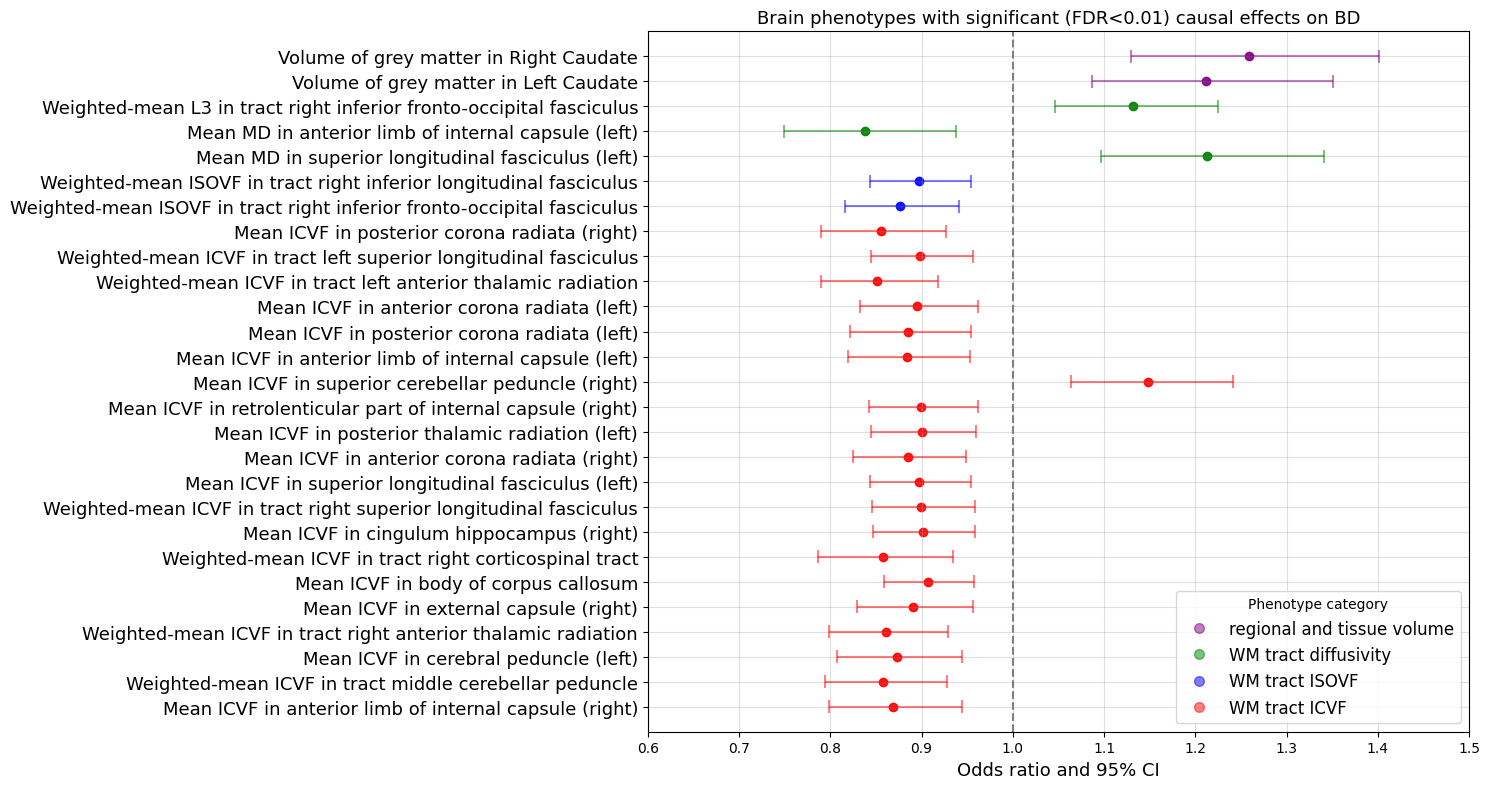

In [91]:
## create plot 
from matplotlib.lines import Line2D
fig,ax = plt.subplots(figsize=(15,8),tight_layout=True)
ax.grid(True,alpha=0.4)
colors_dic = {f"{i}":j for i,j in zip(beta_df_plotting.category.unique(),['red','blue','green','purple'])}
colors=[colors_dic[i] for i in beta_df_plotting.category.values]
yrange=[i for i in range(beta_df_plotting.shape[0])]
ax.set_yticks(yrange)
for i in yrange:
    ax.scatter(beta_df_plotting.iloc[i]['or'],i,c=colors[i],marker='o',alpha=0.9)
    ax.hlines(y=i,xmin=beta_df_plotting.iloc[i]['lwr'],xmax=beta_df_plotting.iloc[i]['upr'],color=colors[i],alpha=0.5)
    ax.vlines(x=[beta_df_plotting.iloc[i]['lwr'],beta_df_plotting.iloc[i]['upr']],ymin=i-0.25,ymax=i+0.25,color=colors[i],alpha=0.5)
ax.vlines(x=1,ymin=-1,ymax=28,linestyle='--',color='gray')
ax.set_ylim(-1,27)

legend_item=[Line2D([0], [0], marker='o', label=i,linestyle='None',
                          markerfacecolor=j, markeredgecolor=j, markersize=7,alpha=0.5) for i,j in colors_dic.items()][::-1]


ax.legend(handles=legend_item,
                       loc='lower right',title='Phenotype category',fontsize=12,)
ax.set_xlabel('Odds ratio and 95% CI',fontsize=13)
ax.set_title('Brain phenotypes with significant (FDR<0.01) causal effects on BD',fontsize=13)
ax.set_xticks(np.arange(0.6,1.6,0.1))
_=ax.set_yticklabels(inter_parse,fontsize=13)
#fig.savefig("fig2A.pdf")

## Figure 2B

Text(0.5, 0, 'SNP $h^2$')

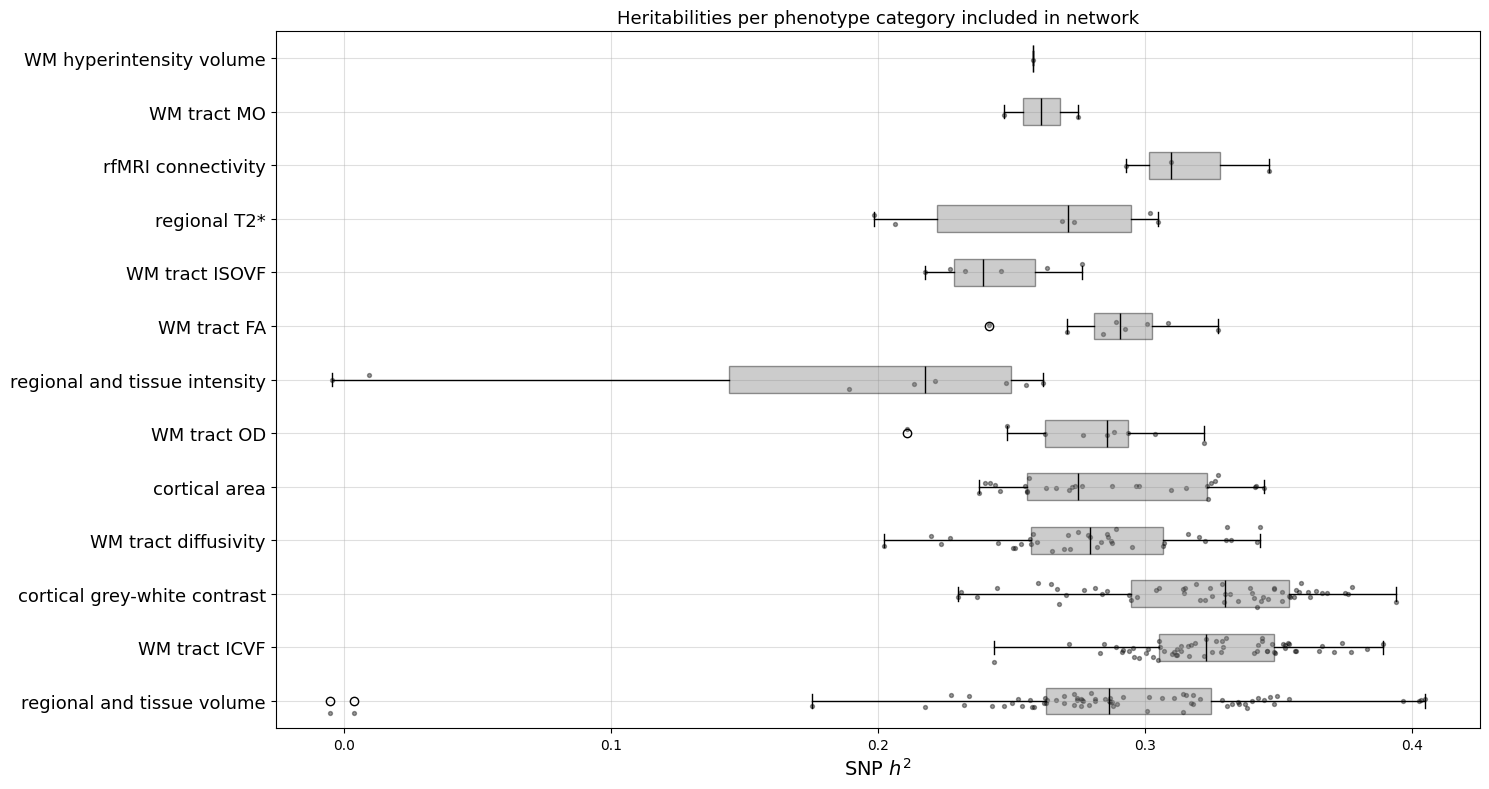

In [94]:
metadata = supp_info.copy()
metadata.index = metadata['Pheno']
metadata_sub = metadata.loc[[int(i) for i in tce.drop('BD',axis=0).index]]
csizes = {f"{i}":metadata_sub[metadata_sub["Category name"]==i].shape[0] for i in metadata_sub['Category name'].unique()}
sort_size = dict(pd.DataFrame(csizes.items()).sort_values(by=1,ascending=False).values)

h2s_sub = {}
for phen in sort_size.keys():
    h2s_sub[phen] = metadata_sub[metadata_sub['Category name']==phen]['Heritability'].values

fig,ax = plt.subplots(figsize=(15,8),tight_layout=True)
ax.grid(alpha=0.4)
bx=ax.boxplot(list(h2s_sub.values()),vert=False,patch_artist = True)
for boxes,medians in zip(bx['boxes'],bx['medians']):
    boxes.set_facecolor('grey')
    boxes.set_alpha(0.4)
    medians.set_color('black')
ax.set_yticks=np.arange(13)
for i in np.arange(13)[::-1]:
    ax.scatter(y=[[i+1] * sort_size[list(sort_size.keys())[i]]] + np.random.normal(0,0.1,sort_size[(list(sort_size.keys())[i])]),
               x=h2s_sub[list(h2s_sub.keys())[i]],s=8,c='black',alpha=0.4)

ax.set_yticklabels([i.replace('white matter','WM') for i in list(sort_size.keys())],fontsize=13)
ax.set_title('Heritabilities per phenotype category included in network',fontsize=13)
ax.set_xlabel(r"SNP $h^2$",fontsize=14)
#fig.savefig("fig2B.pdf")

## Figure 2C (and all other supplementary figures of the same convention)

In [ ]:
import glob
# create dictionary for matching phenotypes in files which are saved as a length 4 code 
name_dic = {str(int(i)):j for i,j in zip(supp_info['Pheno'].values,metadata['IDP short name'].values)}
extra = {}
for i,k in enumerate(name_dic.keys()):
    while len(k) < 4:
        k='0'+k
    extra[k] = name_dic[list(name_dic.keys())[i]]
extra['BD'] = 'BD'
def get_or_for_plot(beta_df_plotting):
    
    beta_df_plotting['or'] = np.exp(beta_df_plotting['b'])
    beta_df_plotting['upr'] = [np.exp(i + (1.96 *j)) for i,j in zip(beta_df_plotting['b'].values,beta_df_plotting['se'].values)]
    beta_df_plotting['lwr'] = [np.exp(i - (1.96 *j)) for i,j in zip(beta_df_plotting['b'].values,beta_df_plotting['se'].values)]
    beta_df_plotting['upr_b'] = [i + (1.96 *j) for i,j in zip(beta_df_plotting['b'].values,beta_df_plotting['se'].values)]
    beta_df_plotting['lwr_b'] = [i - (1.96 *j) for i,j in zip(beta_df_plotting['b'].values,beta_df_plotting['se'].values)]
    
    return beta_df_plotting
def forest_plot(beta_df_plotting,xaxis,pheno1,pheno2):
    
    fig,ax = plt.subplots(figsize=(15,8),tight_layout=True)
    ax.grid(True,alpha=0.4)
    colors = ['red' if i < 0.05 else 'black' for i in beta_df_plotting.pval.values]
    yrange=[i for i in range(beta_df_plotting.shape[0])]
    ax.set_yticks(yrange)
    for i in yrange:
        ax.scatter(beta_df_plotting.iloc[i]['or'],i,c=colors[i],marker='o',alpha=0.9)
        ax.hlines(y=i,xmin=beta_df_plotting.iloc[i]['lwr'],xmax=beta_df_plotting.iloc[i]['upr'],color=colors[i],alpha=0.5)
        ax.vlines(x=[beta_df_plotting.iloc[i]['lwr'],beta_df_plotting.iloc[i]['upr']],ymin=i-0.25,ymax=i+0.25,color=colors[i],alpha=0.5)
    ax.vlines(x=1,ymin=-1,ymax=len(yrange),linestyle='--',color='gray')
    ax.set_ylim(-1,len(yrange))
    
    legend_item=[Line2D([0], [0], marker='o', label='P<0.05',linestyle='None',
                              markerfacecolor='red', markeredgecolor='red', markersize=7,alpha=0.5),
                Line2D([0], [0], marker='o', label='P>0.05',linestyle='None',
                              markerfacecolor='black', markeredgecolor='black', markersize=7,alpha=0.5)]
    
    
    ax.legend(handles=legend_item,
                           loc='lower right',fontsize=12,)
    ax.set_xlabel(xaxis,fontsize=13)
    ax.set_title(f'Effect of {pheno1} on {pheno2} across methods',fontsize=13)
    ax.set_xticks(np.arange(0.6,1.6,0.1))
    _=ax.set_yticklabels(list(beta_df_plotting.method.values),fontsize=13)
    return fig

def forest_plot(beta_df_plotting,xaxis,pheno1,pheno2):
    
    fig,ax = plt.subplots(figsize=(15,8),tight_layout=True)
    ax.grid(True,alpha=0.4)
    colors = ['red' if i < 0.05 else 'black' for i in beta_df_plotting.pval.values]
    yrange=[i for i in range(beta_df_plotting.shape[0])]
    ax.set_yticks(yrange)
    if 'or' in xaxis.lower():
        test_stat = 'or'
        lw = 'lwr'
        up = 'upr'
        noeff = 1
    else:
        test_stat='b'
        lw = 'lwr_b'
        up = 'upr_b'
        noeff = 0
    for i in yrange:
        ax.scatter(beta_df_plotting.iloc[i][test_stat],i,c=colors[i],marker='o',alpha=0.9)
        ax.hlines(y=i,xmin=beta_df_plotting.iloc[i][lw],xmax=beta_df_plotting.iloc[i][up],color=colors[i],alpha=0.5)
        ax.vlines(x=[beta_df_plotting.iloc[i][lw],beta_df_plotting.iloc[i][up]],ymin=i-0.25,ymax=i+0.25,color=colors[i],alpha=0.5)
    
    ax.vlines(x=noeff,ymin=-1,ymax=len(yrange),linestyle='--',color='gray')
    ax.set_ylim(-1,len(yrange))
    
    legend_item=[Line2D([0], [0], marker='o', label='P<0.05',linestyle='None',
                              markerfacecolor='red', markeredgecolor='red', markersize=7,alpha=0.5),
                Line2D([0], [0], marker='o', label='P>0.05',linestyle='None',
                              markerfacecolor='black', markeredgecolor='black', markersize=7,alpha=0.5)]
    
    
    ax.legend(handles=legend_item,
                           loc='lower right',fontsize=12,)
    ax.set_xlabel(xaxis,fontsize=13)
    ax.set_title(f'Effect of {pheno1} on {pheno2} across methods',fontsize=13)
    _=ax.set_yticklabels(list(beta_df_plotting.method.values),fontsize=13)
    return fig
files = glob.glob("*allele_flip.twosamplemr.txt")
upset_df = pd.DataFrame(index=list(pd.read_csv(files[0])['method'].values)+['GSMR2'],columns=[i.split('_plotting')[0] for i in files])
for i in files:
    df = pd.read_csv(i)
    k = i.split('_plotting')[0]
    gsmr_est = pd.read_csv(f'{k}_results.txt',sep=' ')
    df.loc[5] = [5,'exp','out','outcome','exp','GSMR2',df.nsnp.values[0],gsmr_est.bxy.values[0],
                    gsmr_est.se.values[0],gsmr_est.p.values[0]]
    p1 = i.split('_')[0]
    p2 = i.split('_')[2]
    if p1=='BD':
        xax = 'Beta'
    else:
        xax = 'OR'
    upset_df[k]=(df['pval'] < 0.05).values
    fig = forest_plot(get_or_for_plot(df),xax,extra[p1],extra[p2])
  #  fig.savefig(f'{p1}_vs_{p2}_twosamplemr_5_meth_labelled.pdf')

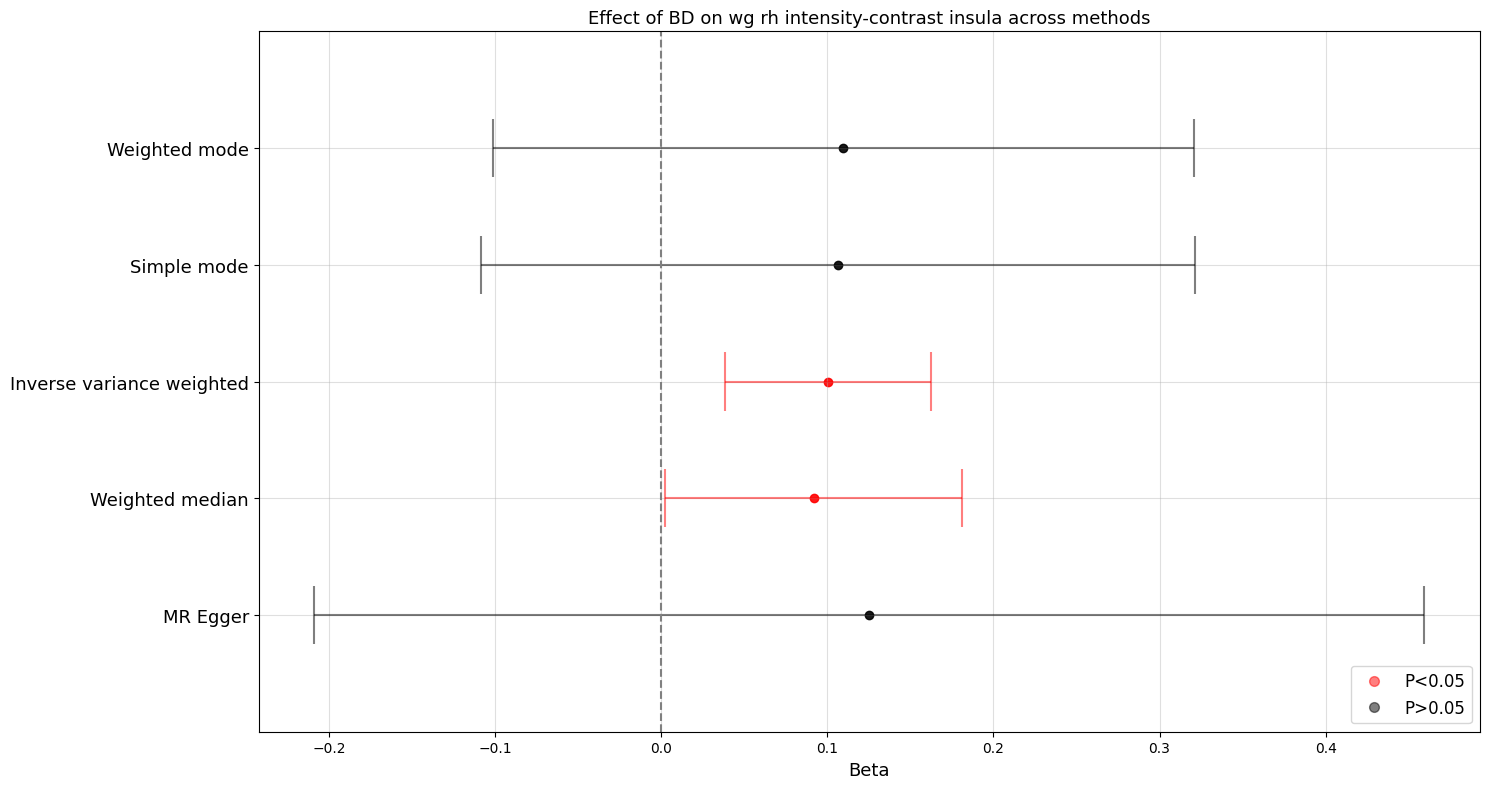

In [167]:
# for just figure 2C 

fig = forest_plot(get_or_for_plot(pd.read_csv("BD_vs_1436_plotting_table.allele_flip.twosamplemr.txt")),'Beta',
                  extra['BD'],extra['1436'])
#fig.savefig("fig2C.pdf")

## Figure 2D 

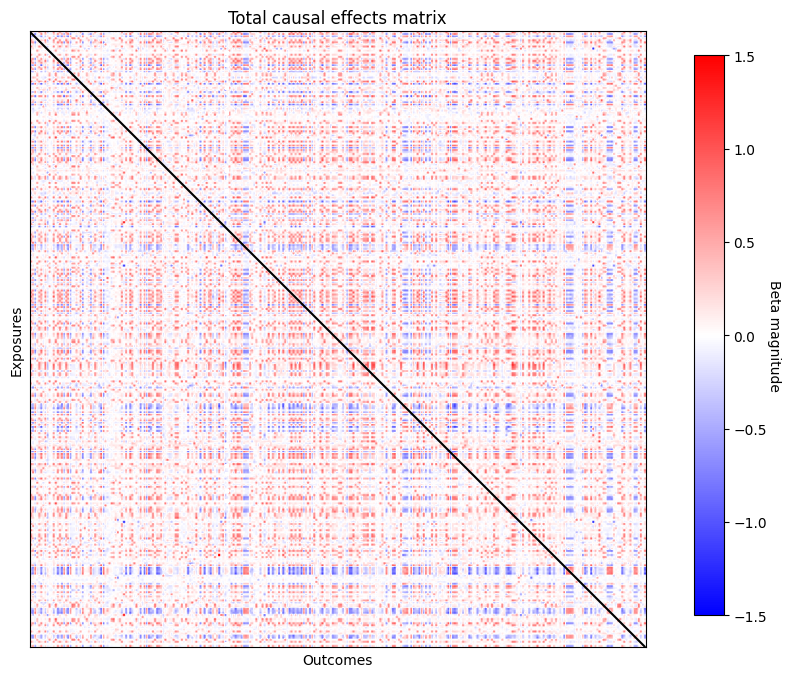

In [114]:
fig,ax1 = plt.subplots(figsize=(15,8))
divnorm=colors_mpl.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
im = ax1.imshow(tce,cmap='bwr',norm=divnorm)
ax1.set_title('Total causal effects matrix')
cbar_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])    
cbar = fig.colorbar(im, cax=cbar_ax,aspect=10)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('Beta magnitude', rotation=270)
ax1.set_xlabel('Outcomes')
ax1.set_ylabel('Exposures')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.plot([i for i in range(298)],c='black')
#fig.savefig("fig2D.pdf")

## Figures 3A and 3B


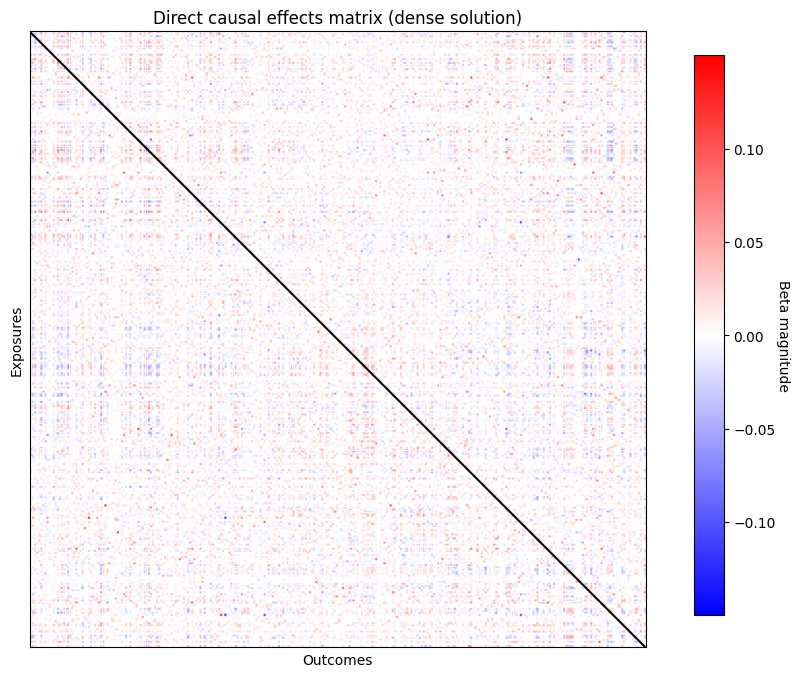

In [117]:
fig,ax1 = plt.subplots(figsize=(15,8))
divnorm=colors_mpl.TwoSlopeNorm(vmin=-0.15, vcenter=0, vmax=0.15)
im = ax1.imshow(dce_dense,cmap='bwr',norm=divnorm)
ax1.set_title('Direct causal effects matrix (dense solution)')
cbar_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])    
cbar = fig.colorbar(im, cax=cbar_ax,aspect=10)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('Beta magnitude', rotation=270)
ax1.set_xlabel('Outcomes')
ax1.set_ylabel('Exposures')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.plot([i for i in range(298)],c='black')
#fig.savefig("fig3A.pdf")

r2 between tce and dce_dense = 0.2136


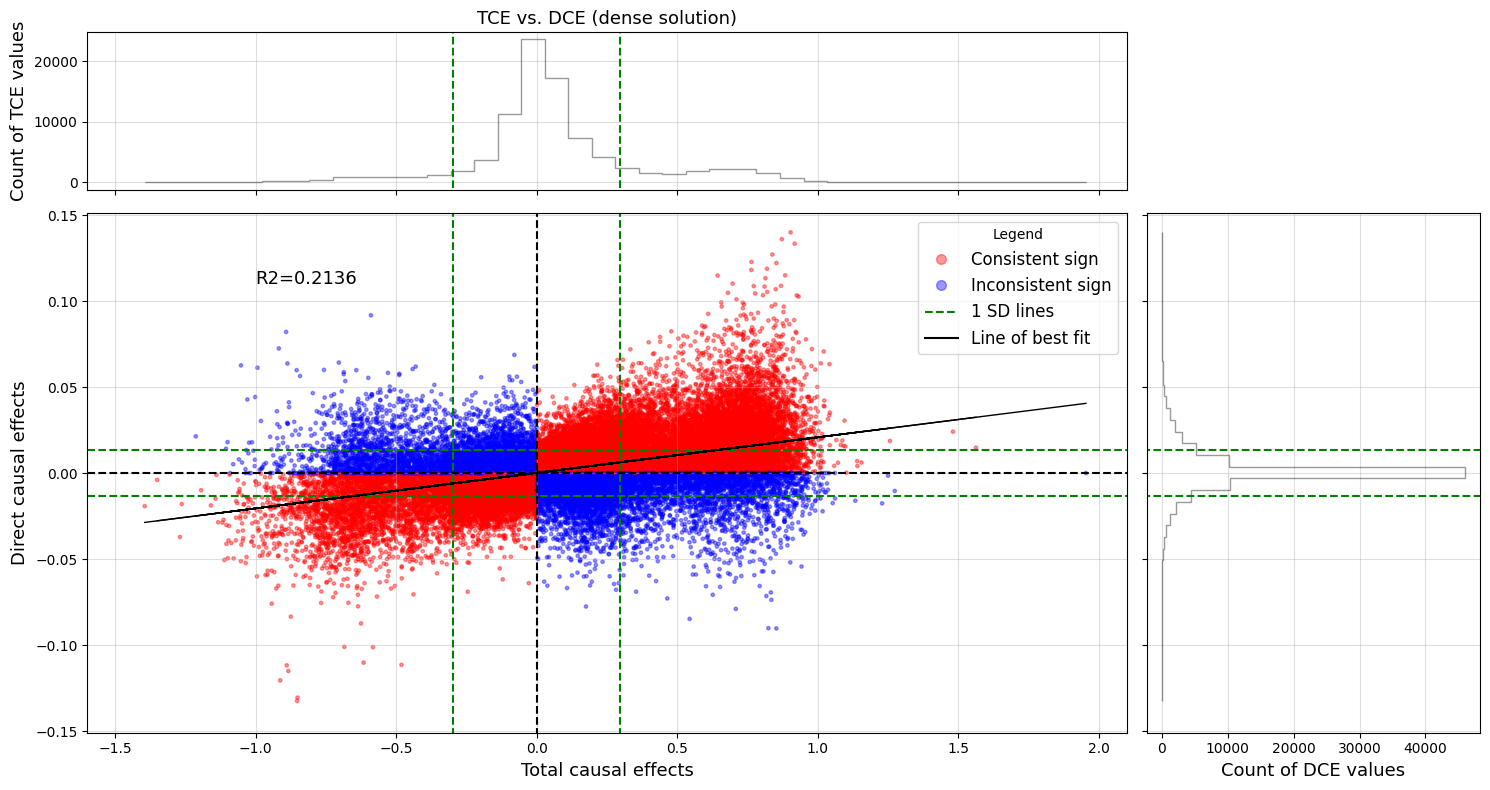

In [122]:
from matplotlib.gridspec import GridSpec
tce = tce.fillna(0)
colors = ['red' if np.sign(i)==np.sign(j) else 'blue' for i,j in zip(tce.values.flatten(),
                                                        dce_dense.values.flatten())]

print(f'r2 between tce and dce_dense = {round(np.corrcoef(tce.values.flatten(),dce_dense.values.flatten())[0,1]**2,4)}')

#fig,ax = plt.subplots(figsize=(15,8))
r2 = round(np.corrcoef(tce.values.flatten(),dce_dense.values.flatten())[0,1]**2,4)

x = np.random.rand(50)
y = np.random.rand(50)

fig = plt.figure(figsize=(15,8))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3],sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1:4,3],sharey=ax_joint)

ax_joint.scatter(tce.values.flatten(),dce_dense.values.flatten(),s=6,c=colors,alpha=0.4)
ax_joint.set_xlabel('TCE input')
ax_joint.set_ylabel('DCE output')
#ax_joint.set_title('TCE values vs. DCE values')
dce_sd = np.std(dce_dense.values.flatten())
tce_sd = np.std(tce.values.flatten())
ax_joint.hlines(y=[-dce_sd,dce_sd],xmin=-3,xmax=3,linestyle='--',color='green')
ax_marg_y.hlines(y=[-dce_sd,dce_sd],xmin=-3,xmax=3,linestyle='--',color='green')

ax_joint.set_xlim((-1.6,2.1))
ax_joint.vlines(x=[-tce_sd,tce_sd],ymin=-3,ymax=3,linestyle='--',color='green')
ax_marg_x.vlines(x=[-tce_sd,tce_sd],ymin=-3,ymax=3,linestyle='--',color='green')

ax_joint.set_ylim((-0.151,0.151))
ax_joint.vlines(x=0,ymin=-3,ymax=3,linestyle='--',color='black')
ax_joint.hlines(y=0,xmin=-3,xmax=3,linestyle='--',color='black')
xseq = np.linspace(tce.min(),tce.max(),100)
b, a = np.polyfit(tce.values.flatten(),dce_dense.values.flatten(), deg=1)
_=ax_joint.plot(xseq, a + b * xseq, color="k", lw=1)
ax_joint.text(-1,0.11,f'R2={r2}',fontsize=13)
legend_item=[Line2D([0], [0], marker='o', label='Consistent sign',linestyle='None',
                          markerfacecolor='red', markeredgecolor='red',alpha=0.4, markersize=7),
             Line2D([0], [0], marker='o', label='Inconsistent sign',linestyle='None',
                          markerfacecolor='blue', markeredgecolor='blue',alpha=0.4, markersize=7),
            Line2D([0], [0], label='1 SD lines', linestyle='--',
                          color='green', markersize=7),
            Line2D([0], [0], label='Line of best fit',linestyle='-',
                          color='black', markersize=7)]
ax_joint.legend(handles=legend_item,
                       loc='upper right',title='Legend',fontsize=12)
ax_joint.grid(alpha=0.4)
ax_marg_x.hist(tce.values.flatten(),color='black',alpha=0.4,bins=40,histtype="step")
ax_marg_y.hist(dce_dense.values.flatten(),orientation="horizontal",bins=40,color='black',alpha=0.4,histtype="step")
ax_marg_x.grid(True,alpha=0.4)
ax_marg_y.grid(True,alpha=0.4)
lms = ax_marg_x.get_ylim()
ax_marg_x.vlines(x=[-tce_sd,tce_sd],ymin=-1000,ymax=25000,linestyle='--',color='green')
ax_marg_x.set_ylim(lms)
lms = ax_marg_y.get_xlim()
ax_marg_y.hlines(y=[-dce_sd,dce_sd],xmin=-18000,xmax=50000,linestyle='--',color='green')
ax_marg_y.set_xlim(lms)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Total causal effects',fontsize=13)
ax_joint.set_ylabel('Direct causal effects',fontsize=13)

# Set labels on marginals
ax_marg_x.set_title("TCE vs. DCE (dense solution)",fontsize=13)
ax_marg_y.set_xlabel('Count of DCE values',fontsize=13)
ax_marg_x.set_ylabel('Count of TCE values',fontsize=13)
plt.tight_layout()
#fig.savefig("fig3B.pdf")

## Figures 3C and 3D

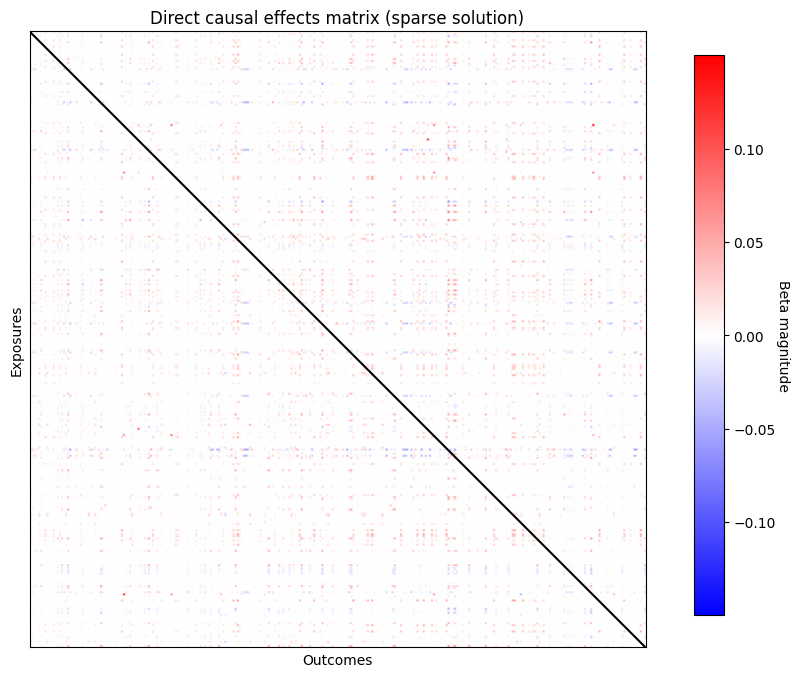

In [123]:
fig,ax1 = plt.subplots(figsize=(15,8))
divnorm=colors_mpl.TwoSlopeNorm(vmin=-0.15, vcenter=0, vmax=0.15)
im = ax1.imshow(dce_sparse,cmap='bwr',norm=divnorm)
ax1.set_title('Direct causal effects matrix (sparse solution)')
cbar_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])    
cbar = fig.colorbar(im, cax=cbar_ax,aspect=10)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('Beta magnitude', rotation=270)
ax1.set_xlabel('Outcomes')
ax1.set_ylabel('Exposures')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.plot([i for i in range(298)],c='black')
#fig.savefig("fig3C.pdf")

r2 between tce and dce_sparse = 0.32


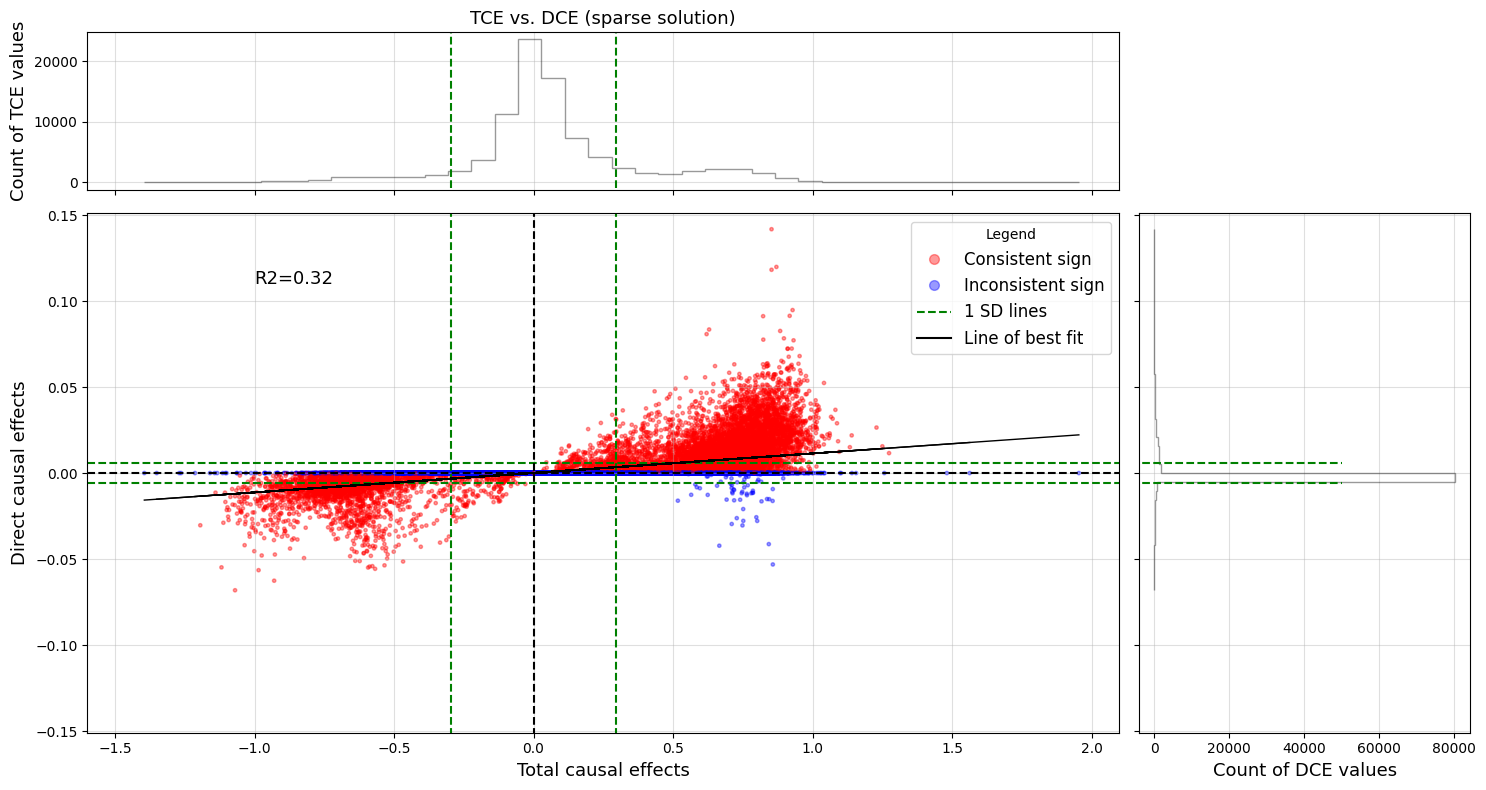

In [124]:
colors = ['red' if np.sign(i)==np.sign(j) else 'blue' for i,j in zip(tce.values.flatten(),
                                                        dce_sparse.values.flatten())]

print(f'r2 between tce and dce_sparse = {round(np.corrcoef(tce.values.flatten(),dce_sparse.values.flatten())[0,1]**2,4)}')

#fig,ax = plt.subplots(figsize=(15,8))
r2 = round(np.corrcoef(tce.values.flatten(),dce_sparse.values.flatten())[0,1]**2,4)

x = np.random.rand(50)
y = np.random.rand(50)

fig = plt.figure(figsize=(15,8))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3],sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1:4,3],sharey=ax_joint)

ax_joint.scatter(tce.values.flatten(),dce_sparse.values.flatten(),s=6,c=colors,alpha=0.4)
ax_joint.set_xlabel('TCE input')
ax_joint.set_ylabel('DCE output')
#ax_joint.set_title('TCE values vs. DCE values')
dce_sd = np.std(dce_sparse.values.flatten())
tce_sd = np.std(tce.values.flatten())
ax_joint.hlines(y=[-dce_sd,dce_sd],xmin=-3,xmax=3,linestyle='--',color='green')
ax_marg_y.hlines(y=[-dce_sd,dce_sd],xmin=-3,xmax=3,linestyle='--',color='green')

ax_joint.set_xlim((-1.6,2.1))
ax_joint.vlines(x=[-tce_sd,tce_sd],ymin=-3,ymax=3,linestyle='--',color='green')
ax_marg_x.vlines(x=[-tce_sd,tce_sd],ymin=-3,ymax=3,linestyle='--',color='green')

ax_joint.set_ylim((-0.151,0.151))
ax_joint.vlines(x=0,ymin=-3,ymax=3,linestyle='--',color='black')
ax_joint.hlines(y=0,xmin=-3,xmax=3,linestyle='--',color='black')
xseq = np.linspace(tce.min(),tce.max(),100)
b, a = np.polyfit(tce.values.flatten(),dce_sparse.values.flatten(), deg=1)
_=ax_joint.plot(xseq, a + b * xseq, color="k", lw=1)
ax_joint.text(-1,0.11,f'R2={r2}',fontsize=13)
legend_item=[Line2D([0], [0], marker='o', label='Consistent sign',linestyle='None',
                          markerfacecolor='red', markeredgecolor='red',alpha=0.4, markersize=7),
             Line2D([0], [0], marker='o', label='Inconsistent sign',linestyle='None',
                          markerfacecolor='blue', markeredgecolor='blue',alpha=0.4, markersize=7),
            Line2D([0], [0], label='1 SD lines', linestyle='--',
                          color='green', markersize=7),
            Line2D([0], [0], label='Line of best fit',linestyle='-',
                          color='black', markersize=7)]
ax_joint.legend(handles=legend_item,
                       loc='upper right',title='Legend',fontsize=12)
ax_joint.grid(alpha=0.4)
ax_marg_x.hist(tce.values.flatten(),color='black',alpha=0.4,bins=40,histtype="step")
ax_marg_y.hist(dce_sparse.values.flatten(),orientation="horizontal",bins=40,color='black',alpha=0.4,histtype="step")
ax_marg_x.grid(True,alpha=0.4)
ax_marg_y.grid(True,alpha=0.4)
lms = ax_marg_x.get_ylim()
ax_marg_x.vlines(x=[-tce_sd,tce_sd],ymin=-1000,ymax=25000,linestyle='--',color='green')
ax_marg_x.set_ylim(lms)
lms = ax_marg_y.get_xlim()
ax_marg_y.hlines(y=[-dce_sd,dce_sd],xmin=-18000,xmax=50000,linestyle='--',color='green')
ax_marg_y.set_xlim(lms)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Total causal effects',fontsize=13)
ax_joint.set_ylabel('Direct causal effects',fontsize=13)

# Set labels on marginals
ax_marg_x.set_title("TCE vs. DCE (sparse solution)",fontsize=13)
ax_marg_y.set_xlabel('Count of DCE values',fontsize=13)
ax_marg_x.set_ylabel('Count of TCE values',fontsize=13)
plt.tight_layout()
#fig.savefig("fig3D.pdf")


## Figure 4A

2.7622527499329413e-28


Text(0.5, 0.98, 'Absolute average effect of BD on phenotypes vs. phenotypes on BD across dce_dense and TCE solutions')

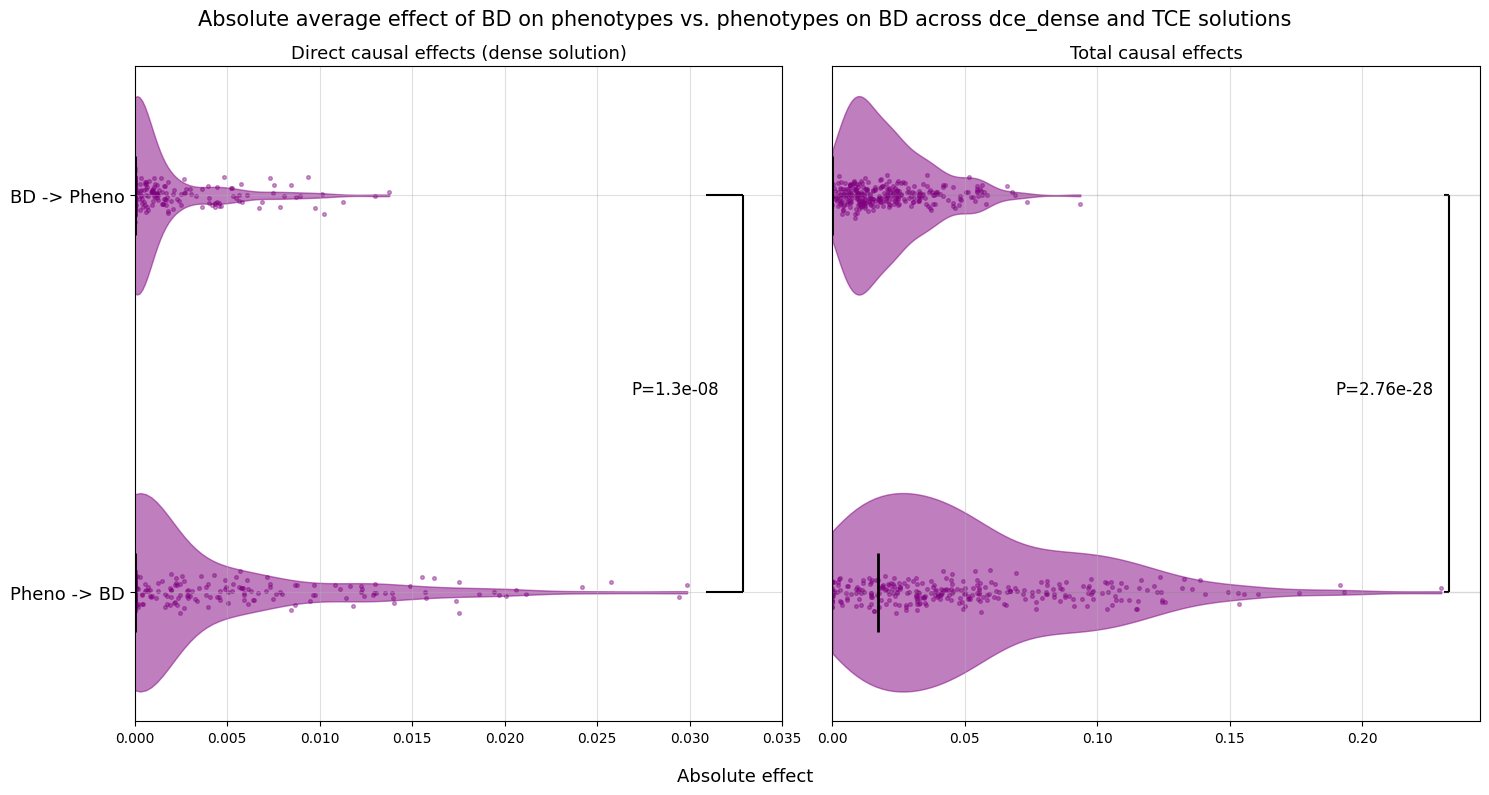

In [126]:
# do statistical tests first 
pval_dce = ttest(dce_dense['BD'].abs(),dce_dense.loc['BD'].abs()).pvalue
pval_tce = ttest(tce['BD'].abs(),tce.loc['BD'].abs()).pvalue
print(pval_tce)
# the rounding is not clean on this number for some reason, hence the hard assignment
pval_tce = 2.76e-28
fig,(ax,ax1)=plt.subplots(ncols=2,figsize=(15,8),tight_layout=True)
bx = ax.violinplot([dce_dense.loc['BD'].abs(),
                   dce_dense['BD'].abs()][::-1],showmedians=False,showextrema=False,vert=False)
ax.scatter(y=[1] * 298+np.random.normal(0,0.02,298),x=dce_dense['BD'].abs(),c='purple',alpha=0.4,s=7,)
ax.scatter(y=[2] * 298+np.random.normal(0,0.02,298),x=dce_dense.loc['BD'].abs(),c='purple',alpha=0.4,s=7,)
ax.grid(alpha=0.4)
for patch in bx['bodies']:
        patch.set_color('purple')
        patch.set_alpha(0.5)
ax.set_yticks([1,2])
ax.set_yticklabels(['Pheno -> BD','BD -> Pheno'],fontsize=13)
ax.set_title('Direct causal effects (dense solution)',fontsize=13)
ax.hlines(y=[1,2],xmin=dce_dense['BD'].abs().max()+0.001,xmax=dce_dense['BD'].abs().max()+0.003,color='black')
ax.vlines(x=dce_dense['BD'].abs().max()+0.003,ymin=1,ymax=2,color='black')
ax.text(y=1.5,x=dce_dense['BD'].abs().max()-0.003,s=f'P={round(pval_dce,9)}',fontsize=12)
ax.set_xlim(0,0.035)

bx = ax1.violinplot([tce.loc['BD'].abs(),
                   tce['BD'].abs()][::-1],showmedians=False,showextrema=False,vert=False)
ax1.scatter(y=[1] * 298+np.random.normal(0,0.02,298),x=tce['BD'].abs(),c='purple',alpha=0.4,s=7,)
ax1.scatter(y=[2] * 298+np.random.normal(0,0.02,298),x=tce.loc['BD'].abs(),c='purple',alpha=0.4,s=7,)
ax1.grid(alpha=0.4)
for patch in bx['bodies']:
        patch.set_color('purple')
        patch.set_alpha(0.5)
ax1.set_yticks([1,2])
ax1.set_yticklabels([])
#ax1.set_yticklabels(['Pheno -> BD','BD -> Pheno'])
ax1.set_title('Total causal effects',fontsize=13)
ax1.hlines(y=[1,2],xmin=tce['BD'].abs().max()+0.001,xmax=tce['BD'].abs().max()+0.003,color='black')
ax1.vlines(x=tce['BD'].abs().max()+0.003,ymin=1,ymax=2,color='black')
ax1.text(y=1.5,x=tce['BD'].abs().max()-0.04,s=f'P={pval_tce}',fontsize=12)
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
yax = ax1.get_yaxis()
yax = yax.set_visible(False)
lims = ax1.get_xlim()
ax1.plot([2] * 10,c='grey',alpha=0.3,lw=1)
ax1.plot([1] * 10,c='grey',alpha=0.3,lw=1)
ax1.set_xlim(0,lims[1])


ax.vlines(x=np.median(dce_dense.loc['BD'].abs()),ymin=.9,ymax=1.1,lw=2,color='black')
ax.vlines(x=np.median(dce_dense['BD'].abs()),ymin=1.9,ymax=2.1,lw=2,color='black')

ax1.vlines(x=np.median(tce.loc['BD'].abs()),ymin=.9,ymax=1.1,lw=2,color='black')
ax1.vlines(x=np.median(dce_dense['BD'].abs()),ymin=1.9,ymax=2.1,lw=2,color='black')
fig.supxlabel('Absolute effect',fontsize=13)
fig.suptitle("Absolute average effect of BD on phenotypes vs. phenotypes on BD across dce_dense and TCE solutions",fontsize=15)
#fig.savefig("fig4A.pdf")

## Figure 4B


Text(0.5, 0.98, 'Out degree in WM and non-WM phenotypes in dense and sparse solutions')

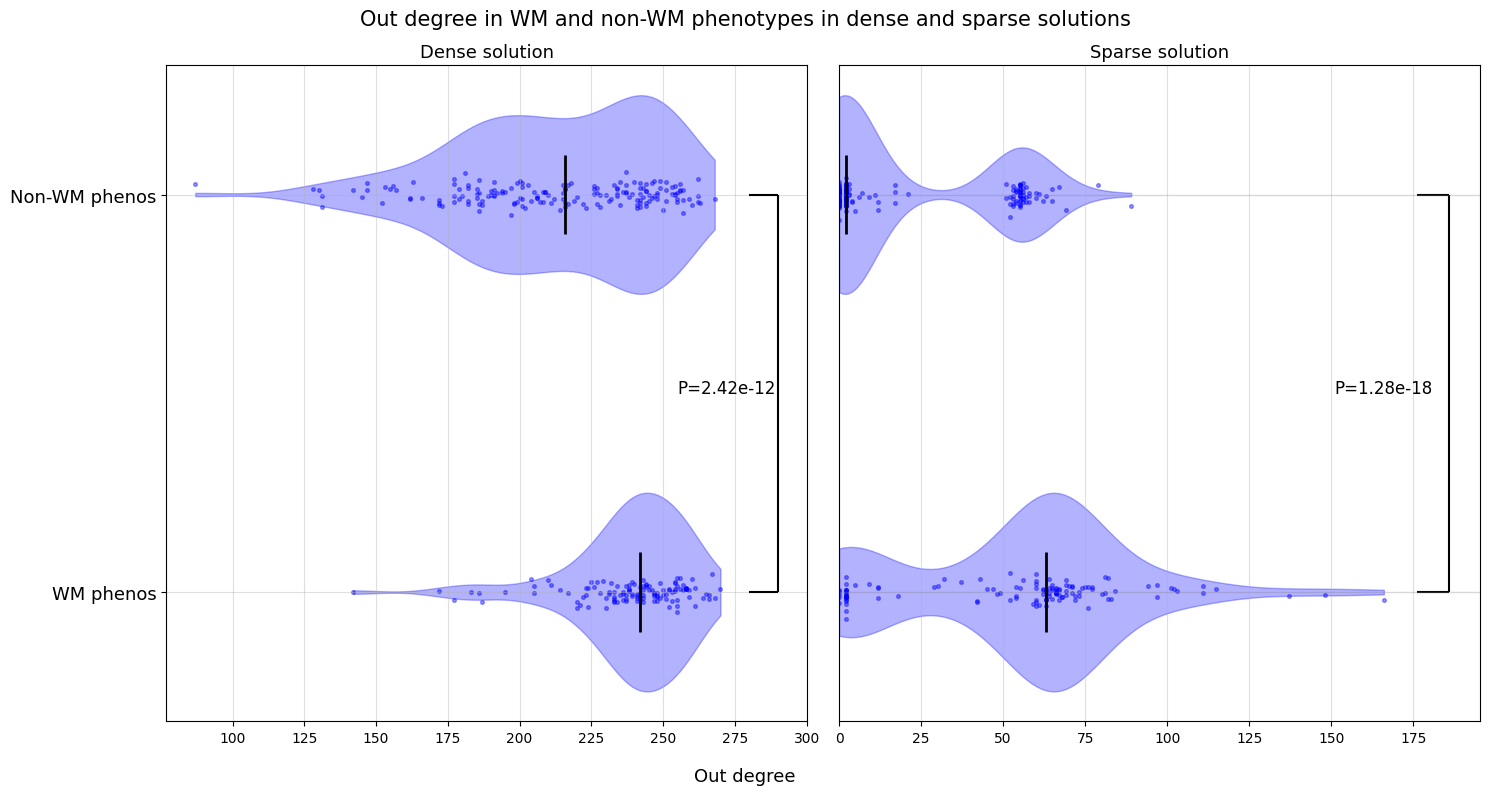

In [134]:
# define meta category assignment 

def meta_category_annotate(dce_annotate):
    
    cdf = pd.DataFrame(dce_annotate.categories.value_counts())
    wdic = {}
    wsum = 0
    for w in cdf.index:
        if 'WM' in w or 'white matter' in w:
            wsum+=cdf.loc[w]
            wdic[w]='white matter'
        else:
            wdic[w] = 'gm/structural'


    dce_annotate['meta-category'] = [wdic[i] for i in dce_annotate['categories']]
    adj_dce = dce_annotate.drop(['categories','meta-category'],axis=1).abs() > 0
    dce_annotate['out_deg'] = [adj_dce.loc[i].sum() for i in dce_annotate.index]
    dce_annotate['in_deg'] = [adj_dce.T.loc[i].sum() for i in dce_annotate.index]
    return dce_annotate

dense_dce_degree = meta_category_annotate(dce_dense_annotate)
sparse_dce_degree = meta_category_annotate(dce_sparse_annotate)

###

dense_plotting = [dense_dce_degree[dense_dce_degree['meta-category']=='white matter']['out_deg'],
      dense_dce_degree[dense_dce_degree['meta-category']!='white matter']['out_deg']]
pval = ttest(dense_plotting[0],dense_plotting[1]).pvalue
pval = str(pval)
pval=pval[:4] + 'e-' + pval[-2:]
sparse_plotting = [sparse_dce_degree[sparse_dce_degree['meta-category']=='white matter']['out_deg'],
      sparse_dce_degree[sparse_dce_degree['meta-category']!='white matter']['out_deg']]
pval_s = ttest(sparse_plotting[0],sparse_plotting[1]).pvalue
pval_s=str(pval_s)
pval_s=pval_s[:4] + 'e-' + pval_s[-2:]
fig,(ax,ax1)=plt.subplots(ncols=2,figsize=(15,8),tight_layout=True)
bx = ax.violinplot(dense_plotting,showmedians=False,showextrema=False,vert=False)
ax.scatter(y=[1] * len(dense_plotting[0])+np.random.normal(0,0.02,len(dense_plotting[0])),x=dense_plotting[0],c='blue',alpha=0.4,s=7,)
ax.scatter(y=[2] * len(dense_plotting[1])+np.random.normal(0,0.02,len(dense_plotting[1])),x=dense_plotting[1],c='blue',alpha=0.4,s=7,)
ax.grid(alpha=0.4)
for patch in bx['bodies']:
        patch.set_color('blue')
        patch.set_alpha(0.3)
ax.set_yticks([1,2])
ax.set_yticklabels(['WM phenos','Non-WM phenos'],fontsize=13)

#ax.set_yticklabels(['Pheno -> BD','BD -> Pheno'])
#ax.set_title('Direct causal effects')
ax.hlines(y=[1,2],xmin=max(dense_plotting[0].max(),dense_plotting[1].max())+10,xmax=max(dense_plotting[0].max(),dense_plotting[1].max())+20,color='black')
ax.vlines(x=max(dense_plotting[0].max(),dense_plotting[1].max())+20,ymin=1,ymax=2,color='black')
ax.text(y=1.5,x=max(dense_plotting[0].max(),dense_plotting[1].max())-15,s=f'P={pval}',fontsize=12)
ax.set_title("Dense solution",fontsize=13)

#ax.set_xlim(0,0.035)

bx = ax1.violinplot(sparse_plotting,showmedians=False,showextrema=False,vert=False)
ax1.scatter(y=[1] * len(sparse_plotting[0])+np.random.normal(0,0.02,len(sparse_plotting[0])),x=sparse_plotting[0],c='blue',alpha=0.4,s=7,)
ax1.scatter(y=[2] * len(sparse_plotting[1])+np.random.normal(0,0.02,len(sparse_plotting[1])),x=sparse_plotting[1],c='blue',alpha=0.4,s=7,)
ax1.grid(alpha=0.4)
for patch in bx['bodies']:
        patch.set_color('blue')
        patch.set_alpha(0.3)
ax1.set_yticks([1,2])
ax1.set_yticklabels([])
ax1.set_title('Sparse solution',fontsize=13)
ax1.hlines(y=[1,2],xmin=max(sparse_plotting[0].max(),sparse_plotting[1].max())+10,xmax=max(sparse_plotting[0].max(),sparse_plotting[1].max())+20,color='black')
ax1.vlines(x=max(sparse_plotting[0].max(),sparse_plotting[1].max())+20,ymin=1,ymax=2,color='black')
ax1.text(y=1.5,x=max(sparse_plotting[0].max(),sparse_plotting[1].max())-15,s=f'P={pval_s}',fontsize=12)
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
yax = ax1.get_yaxis()
yax = yax.set_visible(False)
lims = ax1.get_xlim()
ax1.plot([2] * 300,c='grey',alpha=0.3,lw=1)
ax1.plot([1] * 300,c='grey',alpha=0.3,lw=1)
ax1.set_xlim(0,lims[1])
ax.vlines(x=np.median(dense_plotting[0]),ymin=.9,ymax=1.1,lw=2,color='black')
ax.vlines(x=np.median(dense_plotting[1]),ymin=1.9,ymax=2.1,lw=2,color='black')

ax1.vlines(x=np.median(sparse_plotting[0]),ymin=.9,ymax=1.1,lw=2,color='black')
ax1.vlines(x=np.median(sparse_plotting[1]),ymin=1.9,ymax=2.1,lw=2,color='black')
fig.supxlabel('Out degree',fontsize=13)
fig.suptitle("Out degree in WM and non-WM phenotypes in dense and sparse solutions",fontsize=15)
#fig.savefig("fig4B.pdf")

## Figures 4C and 4D


/Users/oconns04/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


Text(0.5, 1.0, 'Causal relationships between phenotype categories and BD (TCE)')

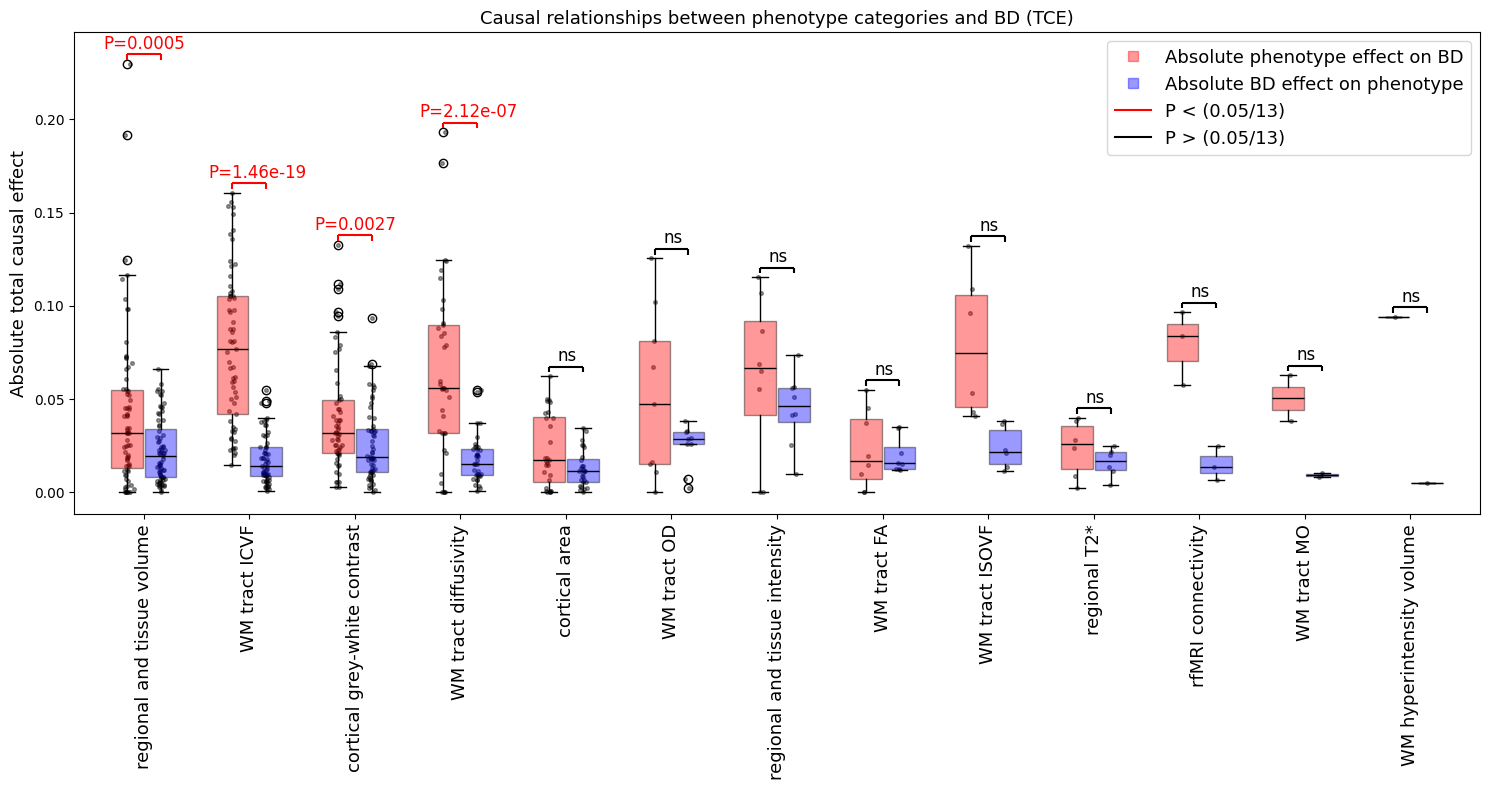

In [137]:
cat_means = {}
tce_annotate = tce_annotate.fillna(0)
for cat in tce_annotate.drop('BD',axis=0)['categories'].unique():
    cat_means[cat]=tce_annotate[tce_annotate.categories==cat]['BD'].abs()

sorted_cat_means=pd.DataFrame({"id":[i for i in cat_means.keys()],"lens":[len(i) for i in cat_means.values()]}).sort_values(by='lens',
                                                                                                                         ascending=False)
sorted_={}
for i in sorted_cat_means.id:
    sorted_[i]=cat_means[i]
sizes=[len(i) for i in cat_means.values()]

## 

cat_means_bd = {}
tce_annotate_transpose = tce_annotate.T
tce_annotate_transpose['categories'] = tce_annotate_transpose.loc['categories']
tce_annotate_transpose = tce_annotate_transpose.drop('categories',axis=0)

for cat in tce_annotate.drop('BD',axis=0)['categories'].unique():
    cat_means_bd[cat]=tce_annotate_transpose[tce_annotate_transpose.categories==cat]['BD'].abs()

sorted_cat_means_bd=pd.DataFrame({"id":[i for i in cat_means_bd.keys()],"lens":[len(i) for i in cat_means_bd.values()]}).sort_values(by='lens',
                                                                                                                         ascending=False)
sorted_bd={}
for i in sorted_cat_means_bd.id:
    sorted_bd[i]=cat_means_bd[i]
##

offset=0.16
fig,ax = plt.subplots(figsize=(15,8),tight_layout=True)
bx1=ax.boxplot(positions=[i+1-offset for i in range(len(sorted_.keys()))],x=sorted_.values(),patch_artist=True,widths=0.3)
bx2=ax.boxplot(positions=[i+1+offset for i in range(len(sorted_bd.keys()))],x=sorted_bd.values(),patch_artist=True,widths=0.3)

pvals = {}

for i in sorted_.keys():
    try:        
        pvals[i] = ttest([j for j in sorted_[i]],[j for j in sorted_bd[i]]).pvalue
    except:
        pvals[i]='NA'

for patch,med in zip(bx1['boxes'],bx1['medians']):
    patch.set_facecolor('red')
    patch.set_alpha(0.4)
    med.set_color('black')
for patch,med in zip(bx2['boxes'],bx2['medians']):
    patch.set_facecolor('blue')
    patch.set_alpha(0.4)
    med.set_color('black')
    
for i in range(len(cat_means.keys())):
    ind=list(sorted_.keys())[i]
    ax.scatter([i+1-offset] * len(list(sorted_.values())[i])+np.random.normal(0,0.02,len(list(sorted_.values())[i])),
               list(sorted_.values())[i],
               c='black',alpha=0.4,s=7)
    
    ax.scatter([i+1+offset] * len(list(sorted_bd.values())[i])+np.random.normal(0,0.02,len(list(sorted_bd.values())[i])),
               list(sorted_bd.values())[i],
               c='black',alpha=0.4,s=7)
    ymax = max([max(list(sorted_.values())[i]),max(list(sorted_bd.values())[i])])
    if pvals[ind]*13<0.05:
        clrs='red'
    else:
        clrs='black'
    if type(pvals[ind])==np.float64:
        e=f'{str(pvals[ind])}'
        p=pvals[ind]
        if 'e' in e:
            e=e[:4] + 'e' + e[-3:]
        else:
            e=e[:6]
    else:
        e=pvals[ind]
    ax.vlines(x=[i+1-offset,i+1+offset],ymin=ymax+0.002,ymax=ymax+0.005,color=clrs)
    ax.hlines(y=ymax+0.005,xmin=i+1-offset,xmax=i+1+offset,color=clrs)
    if p*13 < 0.05:
        
        ax.text(i+1-(offset*2.4),ymax+0.008,f"P={e}",c=clrs,fontsize=12)
    else:
        ax.text(i+1-(offset/2),ymax+0.008,'ns',c=clrs,fontsize=12)

#ax.grid()
#ax.set_title('Absolute effect of different phenotype categories on BD')
ax.set_xticks([i+1 for i in range(len(sorted_.keys()))])
ax.set_xticklabels([i.replace('white matter','WM') for i in sorted_.keys()],rotation=90,fontsize=13)
ax.set_ylabel('Absolute total causal effect',fontsize=13)


legend_item=[Line2D([0], [0], marker='s', label='Absolute phenotype effect on BD',linestyle='None',
                          markerfacecolor='red', markersize=7,markeredgecolor='red',alpha=0.4),
            Line2D([0], [0], marker='s', label='Absolute BD effect on phenotype', linestyle='None',
                          markerfacecolor='blue', markersize=7,markeredgecolor='blue',alpha=0.4),
            Line2D([0], [0], label='P < (0.05/13)',linestyle='-',
                   markersize=7,color='red'),
            Line2D([0], [0], label='P > (0.05/13)',linestyle='-',
                   markersize=7,color='black')]

ax.legend(handles=legend_item,
                       loc='upper right',fontsize=13)
ax.set_title('Causal relationships between phenotype categories and BD (TCE)',fontsize=13)
#fig.savefig("fig4C.pdf")

/Users/oconns04/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


Text(0.5, 1.0, 'Causal relationships between phenotype categories and BD (dense DCE)')

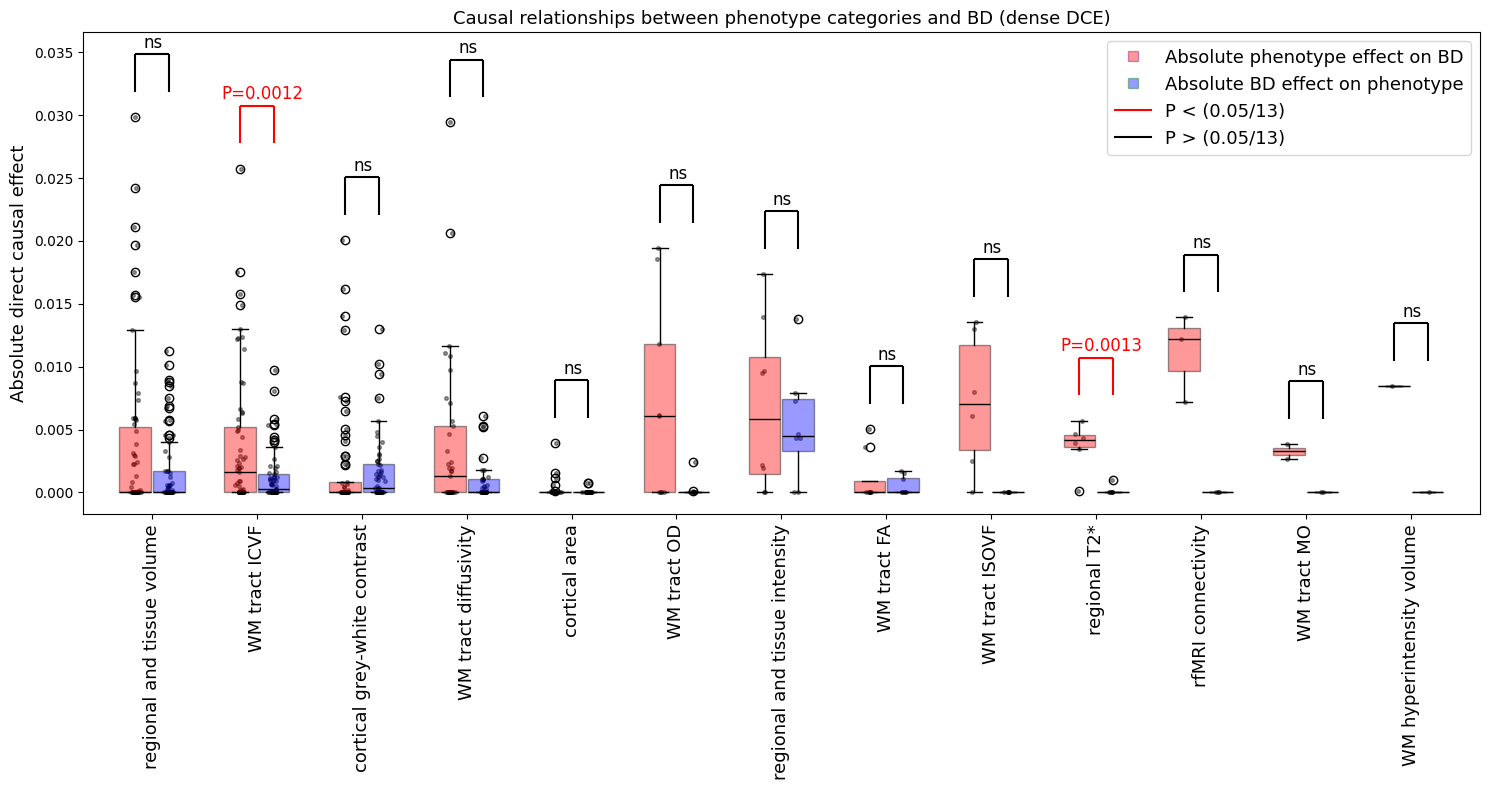

In [138]:
cat_means = {}
for cat in dce_dense_annotate.drop('BD',axis=0)['categories'].unique():
    cat_means[cat]=dce_dense_annotate[dce_dense_annotate.categories==cat]['BD'].abs()
    
sorted_cat_means=pd.DataFrame({"id":[i for i in cat_means.keys()],"lens":[len(i) for i in cat_means.values()]}).sort_values(by='lens',
                                                                                                                             ascending=False)
sorted_={}
for i in sorted_cat_means.id:
    sorted_[i]=cat_means[i]
sizes=[len(i) for i in cat_means.values()]
cat_means_bd = {}
dce_dense_annotate_transpose = dce_dense_annotate.T
dce_dense_annotate_transpose['categories'] = dce_dense_annotate_transpose.loc['categories']
dce_dense_annotate_transpose = dce_dense_annotate_transpose.drop('categories',axis=0)

for cat in dce_dense_annotate.drop('BD',axis=0)['categories'].unique():
    cat_means_bd[cat]=dce_dense_annotate_transpose[dce_dense_annotate_transpose.categories==cat]['BD'].abs()

sorted_cat_means_bd=pd.DataFrame({"id":[i for i in cat_means_bd.keys()],"lens":[len(i) for i in cat_means_bd.values()]}).sort_values(by='lens',
                                                                                                                         ascending=False)
sorted_bd={}
for i in sorted_cat_means_bd.id:
    sorted_bd[i]=cat_means_bd[i]
sizes=[len(i) for i in cat_means_bd.values()]
tit='Absolute DCE between phenotype categories and BD (Dense solution)'

offset=0.16
fig,ax = plt.subplots(figsize=(15,8),tight_layout=True)
bx1=ax.boxplot(positions=[i+1-offset for i in range(len(sorted_.keys()))],x=sorted_.values(),patch_artist=True,widths=0.3)
bx2=ax.boxplot(positions=[i+1+offset for i in range(len(sorted_bd.keys()))],x=sorted_bd.values(),patch_artist=True,widths=0.3)
    
pvals = {}
    
for i in sorted_.keys():
    pvals[i] = ttest([j for j in sorted_[i]],[j for j in sorted_bd[i]]).pvalue
for patch,med in zip(bx1['boxes'],bx1['medians']):
    patch.set_facecolor('red')
    patch.set_alpha(0.4)
    med.set_color('black')
for patch,med in zip(bx2['boxes'],bx2['medians']):
    patch.set_facecolor('blue')
    patch.set_alpha(0.4)
    med.set_color('black')
    
for i in range(len(cat_means.keys())):
    ind=list(sorted_.keys())[i]
    ax.scatter([i+1-offset] * len(list(sorted_.values())[i])+np.random.normal(0,0.02,len(list(sorted_.values())[i])),
               list(sorted_.values())[i],
               c='black',alpha=0.4,s=7)
    
    ax.scatter([i+1+offset] * len(list(sorted_bd.values())[i])+np.random.normal(0,0.02,len(list(sorted_bd.values())[i])),
               list(sorted_bd.values())[i],
               c='black',alpha=0.4,s=7)
    ymax = max([max(list(sorted_.values())[i]),max(list(sorted_bd.values())[i])])
    if type(pvals[ind])==np.float64:
        e=f'{round(pvals[ind],4)}'
        if pvals[ind]*13<0.05:
            clrs='red'
        else:
            clrs='black'
    else:
        e=pvals[ind]
        clrs='black'
        
    ax.vlines(x=[i+1-offset,i+1+offset],ymin=ymax+0.002,ymax=ymax+0.005,color=clrs)
    ax.hlines(y=ymax+0.005,xmin=i+1-offset,xmax=i+1+offset,color=clrs,)
    if float(e)*13 < 0.05:
        ax.text(i+1-(offset*2.1),ymax+0.0055,f'P={e}',c=clrs,fontsize=12)
    else:
        ax.text(i+1-(offset/2),ymax+0.0055,'ns',c=clrs,fontsize=12)


#ax.grid(alpha=0.4)
ax.set_xticks([i+1 for i in range(len(sorted_.keys()))])
ax.set_xticklabels([i.replace('white matter','WM') for i in sorted_.keys()],rotation=90,fontsize=13)
ax.set_ylabel('Absolute direct causal effect',fontsize=13)


legend_item=[Line2D([0], [0], marker='s', label='Absolute phenotype effect on BD',linestyle='None',
                      markerfacecolor='red', markersize=7,markeredgecolor='purple',alpha=0.4),
        Line2D([0], [0], marker='s', label='Absolute BD effect on phenotype', linestyle='None',
                      markerfacecolor='blue', markersize=7,markeredgecolor='green',alpha=0.4),
        Line2D([0], [0], label='P < (0.05/13)',linestyle='-',
               markersize=7,color='red'),
        Line2D([0], [0], label='P > (0.05/13)',linestyle='-',
               markersize=7,color='black')]

ax.legend(handles=legend_item,
                   loc='upper right',fontsize=13)
ax.set_title('Causal relationships between phenotype categories and BD (dense DCE)',fontsize=13)
#fig.savefig("fig4D.pdf")

## Figure 5
These 4 panels were constructed in Cytoscape. To obtain the edge lists in a cytoscape-friendly format, run the code below:

In [149]:
import networkx as nx
def make_network(df,metadata):
    

    G_bd_as_exp = nx.from_pandas_adjacency(df,create_using=nx.DiGraph)
    elist = nx.to_pandas_edgelist(G_bd_as_exp)
    elist['source_cat'] = [metadata[metadata['IDP short name']==i]['Category name'].values[0] if i!='BD' else 'BD'
                             for i in list(elist.source.values)
                            ]
    elist['abs_weight'] = elist.weight.abs()
    return elist
    
# top 20 effectors of BD net


dense_net = dce_dense_annotate.loc[
list(dce_dense_annotate.drop('categories',axis=1)['BD'].abs().sort_values(ascending=False)[:20].index) + ['BD'] # rows
][
list(dce_dense_annotate.drop('categories',axis=1)['BD'].abs().sort_values(ascending=False)[:20].index) + ['BD'] # columns
]

dense_net_elist = make_network(dense_net,supp_info)
pruned_dense_net_elist = dense_net_elist[dense_net_elist['abs_weight'] > np.std(dce_dense.values.flatten())]

#pruned_dense_net_elist.to_csv("fig5_data_dense.csv")
# the same can be done for the sparse matrix



In [162]:
nz_sparse = dce_sparse_annotate[dce_sparse_annotate['BD'].abs() != 0].index

nz_entries_sparse_df = dce_sparse_annotate.loc[list(nz_sparse) + ['BD']][list(nz_sparse) + ['BD']]
sparse_net_elist = make_network(nz_entries_sparse_df,supp_info)
pruned_sparse_net_elist = sparse_net_elist[sparse_net_elist['abs_weight'] > np.std(dce_sparse.values.flatten())]

#pruned_sparse_net_elist.to_csv("fig5_data_sparse.csv")

## Supplementary information 

In [ ]:
## variant exposure - variant outcome plots
n_instr_dic = {}
fls = glob.glob('*plotting_table.txt')
for pheno in fls:
    lab = pheno.split('_')[0]
    lab2=pheno.split('_')[2]
    stats = pd.read_csv(pheno,sep=' ')
    fig,ax = plt.subplots(figsize=(15,8))
    ax.scatter(stats.b,stats.b_y,c='black',marker='+',s=10,alpha=0.7)
    ax.grid(alpha=0.4)
    ax.hlines(y=stats.b_y,xmin=stats.b-stats.se,xmax=stats.b+stats.se,color='black',linewidth=2,alpha=0.7)
    ax.vlines(x=stats.b,ymin=stats.b_y-stats.se_y,ymax=stats.b_y+stats.se_y,color='black',linewidth=2,alpha=0.7)
    slope = tce_annotate.loc[extra[lab]][extra[lab2]]
    se=tce_se_annotate.loc[extra[lab]][extra[lab2]]
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.plot(np.linspace(min(stats.b)-0.4,max(stats.b)+0.4,100),0+np.linspace(min(stats.b)-0.4,max(stats.b+0.4),100)*slope,linestyle='--',color='r')
    p_df = pd.DataFrame({"x_est":np.linspace(min(stats.b)-0.4,max(stats.b)+0.4,100),
                        "x_up":0+np.linspace(min(stats.b)-0.4,max(stats.b+0.4),100)*slope + se,
                        "x_lo":0+np.linspace(min(stats.b)-0.4,max(stats.b+0.4),100)*slope - se})
    ax.fill_between(p_df.x_est,p_df.x_lo,p_df.x_up,alpha=0.1,color='gray',)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel(f"SNP effect on exposure {extra[lab]} ($\\beta zx$)")
    ax.set_ylabel(f"SNP effect on outcome {extra[lab2]} ($\\beta zy$)")
    ax.set_title(f"SNP effect in {extra[lab]} and {extra[lab2]}")
    legend_item=[Line2D([0], [0], label=f'$\\beta xy \\pm se$ = {round(se,4)}', marker='s',markerfacecolor='gray',
                        markeredgecolor='gray',
                        alpha=0.4,
                        linestyle='None',
                          color='gray', markersize=7),
            Line2D([0], [0], label=f'$\\beta xy$ = {round(slope,4)}',linestyle='--',
                          color='red', markersize=7)][::-1]

    ax.legend(handles=legend_item,
                       loc='upper right',fontsize=10)
    n_instr_dic[lab] = stats.shape[0]

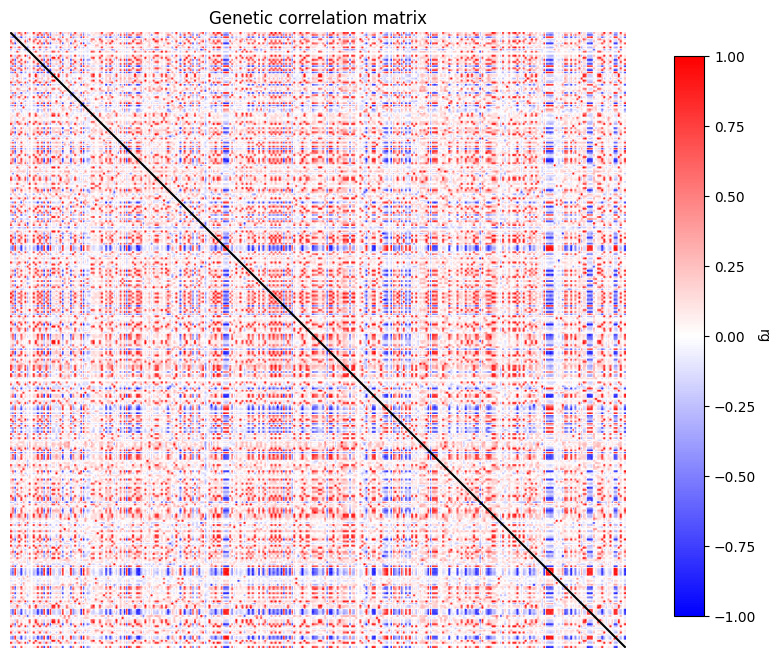

In [180]:
## plotting genetic correlation df 
rgdf = pd.read_csv("rgdf_unannotated.csv",index_col=0)
fig,ax1 = plt.subplots(figsize=(15,8))
divnorm=colors_mpl.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = ax1.imshow(rgdf,cmap='bwr',norm=divnorm)
ax1.set_title('Genetic correlation matrix')
ax1.axis('off')
cbar_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])    
cbar = fig.colorbar(im, cax=cbar_ax,aspect=10)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('rg', rotation=270)
ax1.plot([i for i in range(298)],c='black')

In [ ]:
## bonus code for creating annotated interactive rgdf 
rgdf.index = [extra[i] for i in rgdf.index]
rgdf.columns = [extra[i] for i in rgdf.columns]

import plotly.express as px
import plotly.graph_objects as go

fig = px.imshow(rgdf,
                labels=dict(x="Phenotype 1", y="Phenotype 2",
                            color="rg"),color_continuous_scale='balance',
               title='Interactive genetic correlation matrix')

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
yaxis={'visible': False, 'showticklabels': False},
xaxis={'visible': False, 'showticklabels': False})
#fig.add_trace(go.Contour(z=x_annot,
 #                        showscale=False,
  #                       showlegend=False,opacity=0.2))
fig.show()

In [189]:
loo_files

['1925_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1619_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1934_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1905_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1914_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1952_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1918_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1943_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1972_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1938_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '0125_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1929_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1966_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '2115_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1953_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1919_vs_BD_plotting_table.allele_flip.loo_twosamplemr.txt',
 '1971_v

Text(0.5, 1.0, 'Leave-one-out $\\beta$ estimates using IVW')

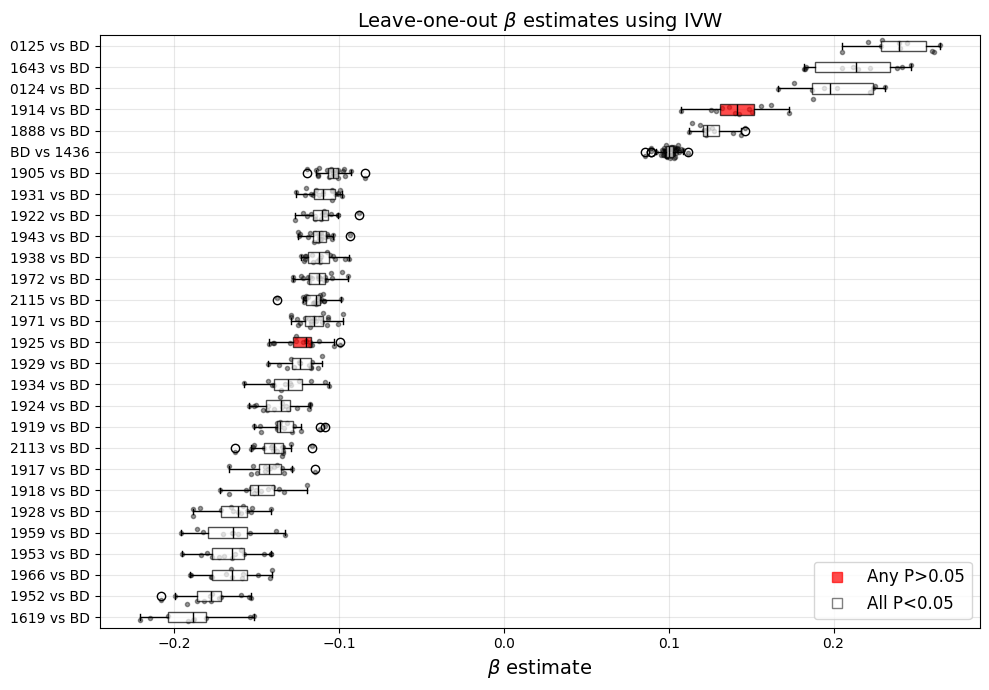

In [190]:
## leave one out results 
fig,ax=plt.subplots(figsize=(10,7),tight_layout=True)
loo_files = glob.glob("*allele_flip.loo_twosamplemr.txt")
labs = [' '.join(i.split('_plotting')[0].split('_')) for i in loo_files]
len(loo_files)
data_median = [np.median(pd.read_csv(i).b.values) for i in loo_files]
colors = ['red' if np.any(pd.read_csv(i).p.values > 0.05) else 'white' for i in loo_files]
df_plot = pd.DataFrame({"lab":labs,"data":data_median,"colors":colors,"ind":[i for i in range(28)]})
df_plot=df_plot.sort_values(by='data')
data = [pd.read_csv(loo_files[i]).b.values for i in df_plot.ind]
b=ax.boxplot(data,patch_artist=True,vert=False,)
for b,med,c in zip(b['boxes'],b['medians'],df_plot.colors):
    b.set_facecolor(c,)
    b.set_alpha(0.7)
    med.set_color("black")
legend_item=[Line2D([0], [0], marker='s', label='Any P>0.05',linestyle='None',
                              markerfacecolor='red', markeredgecolor='red', markersize=7,alpha=0.7),
                Line2D([0], [0], marker='s', label='All P<0.05',linestyle='None',
                              markerfacecolor='white', markeredgecolor='black', markersize=7,alpha=0.5)]
ax.grid(alpha=.3)
ax.legend(handles=legend_item,
                           loc='lower right',fontsize=12,)
ax.set_yticks([i+1 for i in range(len(loo_files))])
ax.set_yticklabels(df_plot.lab)
for i in range(28):
    ax.scatter(y=[i+1]*len(data[i]) + np.random.normal(0,0.15,len(data[i])),x=data[i],c='black',alpha=0.4,s=9)

ax.set_xlabel(r'$\beta$ estimate',fontsize=14)
ax.set_title(r'Leave-one-out $\beta$ estimates using IVW',fontsize=14)

Text(0.5, 0.98, 'Comparison of betas and p-values before and after sensitivity analysis')

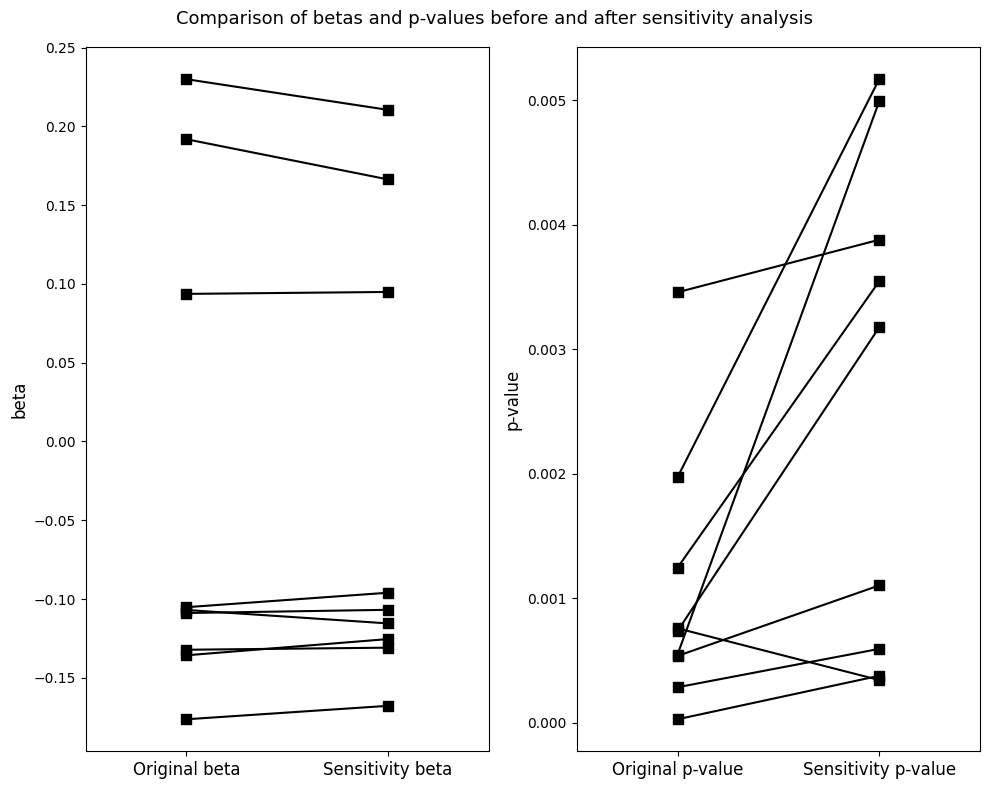

In [200]:
## confounder changes 
files = glob.glob("*txt_results*")
keys = [i.split('_plotting_')[0] for i in files]
res_files = [glob.glob(f'{k}_results.txt')[0] for k in keys] 
pvals_sens = [pd.read_csv(i,sep=' ').p.values[0] for i in files]
pvals_reg = [pd.read_csv(i,sep=' ').p.values[0] for i in res_files]
fig,(ax,ax1) = plt.subplots(figsize=(10,8),ncols=2,tight_layout=True)

ax.scatter([0.5]*len(files),beta_reg,c='black',s=45,marker='s')
ax.scatter([0.7]*len(files),beta_sens,c='black',s=45,marker='s')
for i,j in zip(beta_reg,beta_sens):
    
    ax.plot([0.5,0.7],[i,j],c='black')
ax.set_xlim(0.4,0.8)

ax.set_xticks([0.5,0.7])
ax.set_xticklabels(['Original beta','Sensitivity beta'],fontsize=12)
ax.set_ylabel('beta',fontsize=12)
ax1.scatter([0.5]*len(files),pvals_reg,c='black',s=45,marker='s')
ax1.scatter([0.7]*len(files),pvals_sens,c='black',s=45,marker='s')
for i,j in zip(pvals_reg,pvals_sens):
    
    ax1.plot([0.5,0.7],[i,j],color='black',)
ax1.set_xlim(0.4,0.8)

ax1.set_xticks([0.5,0.7])
ax1.set_xticklabels(['Original p-value','Sensitivity p-value'],fontsize=12)
ax1.set_ylabel('p-value',fontsize=12)
fig.suptitle('Comparison of betas and p-values before and after sensitivity analysis',fontsize=13)
